In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Data Pre-processing

Don't need to run this if you already have 'full_fz_efg_sub'

In [ ]:
product_attribute = pd.read_excel('/Users/fuqiaozhi/Desktop/UTD Semesters/Spring 2024/BUAN 6337/Conagra Cleaned Data/Product Attributes.xlsx')
fz_meat = pd.read_excel('/Users/fuqiaozhi/Desktop/UTD Semesters/Spring 2024/BUAN 6337/Conagra Data/Data/Fz_Rfg Substitute Meat_POS_2020.xlsx')
fz_meat2 = pd.read_excel('/Users/fuqiaozhi/Desktop/UTD Semesters/Spring 2024/BUAN 6337/Conagra Data/Data/Fz_Rfg Substitute Meat_POS_2021.xlsx')
fz_meat3 = pd.read_excel('/Users/fuqiaozhi/Desktop/UTD Semesters/Spring 2024/BUAN 6337/Conagra Data/Data/Fz_Rfg Substitute Meat_POS_2022.xlsx')
fz_meat4 = pd.read_excel('/Users/fuqiaozhi/Desktop/UTD Semesters/Spring 2024/BUAN 6337/Conagra Data/Data/Fz_Rfg Substitute Meat_POS_2023.xlsx')
fz_meat5 = pd.read_excel('/Users/fuqiaozhi/Desktop/UTD Semesters/Spring 2024/BUAN 6337/Conagra Data/Data/Fz_Rfg Substitute Meat_POS_2024.xlsx')

In [ ]:
# Imputation
def imputation_process(row):
    row['Incremental Units'] = row['Unit Sales'] - row['Base Unit Sales']
    row['Incremental Volume'] = row['Volume Sales'] - row['Base Volume Sales']
    row['Incremental Dollars'] = row['Dollar Sales'] - row['Base Dollar Sales']
    return row

# Split Geography column and only save its location
def extract_location(col):
    return col.split(' - ')[0]

# convert time into year month and day
def parse_time(col):
    # Year, month, day
    sep_data = col.split('-')
    year = int('20' + sep_data[2])
    month = int(sep_data[0][-2:])
    day = int(sep_data[1])
    # Quarter of given date
    quarter = (month - 1) // 3 + 1
    return pd.Series([year, quarter, month], index = ['Year', 'Quarter', 'Month'])

# Split product column and only save company name and product name
def parse_product(col):  
    return col.split(' - ')[0]


# Based on length of company name, select product name
def extract_product_name(full_string, brand_name):
    brand_name_length = len(brand_name)
    words = full_string[brand_name_length:].strip()
    return words

# # Arrange columns order
def change_column_order(df):
    final_order = [
        'Geography', 'Year', 'Quarter', 'Month', 'Season', 'Form', 'Manufacturer Name',
        'Brand Name', 'Product Name', 'Flavor / Scent', 'Meat Source',
        'Unit Sales', 'Volume Sales', 'Dollar Sales', 'Price per Unit', 
        'Price per Volume', 'Base Unit Sales', 'Base Volume Sales', 'Base Dollar Sales',
        'Incremental Units', 'Incremental Volume', 'Incremental Dollars', 
        'ACV Weighted Distribution'
    ]
    return df[final_order]

def merge_content(df1, df2):
    combined = df1.merge(df2, how = 'left', on = 'Product')
    return combined

def map_season(month):
    # Northern Hemisphere standard mapping
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'


# Full tranform process
def transform_data(df, df2):
    table1 = merge_content(df, df2)
    # Used customized function
    table1['Geography'] = table1['Geography'].map(extract_location)
    table1[['Year', 'Quarter', 'Month']] = table1['Time'].apply(parse_time)
    table1['Product'] = table1['Product'].map(parse_product)
    table1['Product Name'] = table1.apply(lambda row: extract_product_name(row['Product'], row['Brand Name']), axis=1)
    #df['Product Name'] = df.apply(extract_product_name(df['Product'], df['Brand']), axis = 1)
    
    # Mapping quarter to seasonality
    table1['Season'] = table1['Month'].apply(map_season)
    # Change column order
    transformed = change_column_order(table1).apply(imputation_process, axis = 1)
    return transformed

In [ ]:
combined = transform_data(fz_meat, product_attribute)
combined2 = transform_data(fz_meat2, product_attribute)
combined3 = transform_data(fz_meat3, product_attribute)
combined4 = transform_data(fz_meat4, product_attribute)
combined5 = transform_data(fz_meat5, product_attribute)

In [ ]:
full_fz_rfg_sub = pd.concat([combined, combined2, combined3, combined4, combined5])

## Data Loading

In [3]:
full_fz_rfg_sub = pd.read_csv('/Users/fuqiaozhi/Desktop/UTD Semesters/Spring 2024/BUAN 6337/full_fz_rfg_sub.csv')
full_fz_rfg_sub = full_fz_rfg_sub[full_fz_rfg_sub['Geography'] != 'Total US']

In [4]:
top_n = full_fz_rfg_sub.groupby(['Manufacturer Name']).agg({'Dollar Sales':'sum'}).sort_values(by = 'Dollar Sales',ascending = False)
total_dollar_sales = sum(top_n['Dollar Sales'])
print(total_dollar_sales)
new_top_n = top_n[0:7]
new_top_n_total = sum(new_top_n['Dollar Sales'])
print(new_top_n_total)
new_top_n_total / total_dollar_sales

4858463573.5520115
3912869926.298861


0.8053718767388371

Simply shows that total sales from top 7 companies cover 80% of total sales from all companies during 2020-2024

In [5]:
new_top_n = new_top_n.reset_index()
top7_list = new_top_n['Manufacturer Name']

In [6]:
# Top 7 Manufacturers
regex_pattern = '|'.join(top7_list)
filtered_df = full_fz_rfg_sub[(full_fz_rfg_sub['Manufacturer Name'].str.contains(regex_pattern, case=False, na=False)) & (full_fz_rfg_sub['Year'] != 2024)]

In [7]:
filtered_df['Manufacturer Name'].unique()

array(['BEYOND MEAT INC', 'CONAGRA BRANDS', 'KELLANOVA', 'PRIVATE LABEL',
       'TURTLE ISLAND FOODS INC', 'LIGHTLIFE FOODS INC',
       'IMPOSSIBLE FOODS INC'], dtype=object)

In [8]:
filtered_df['Year'].unique()

array([2020, 2021, 2022, 2023])

# Part 1

## Analysis on Top 7 Manufacturer & Sales

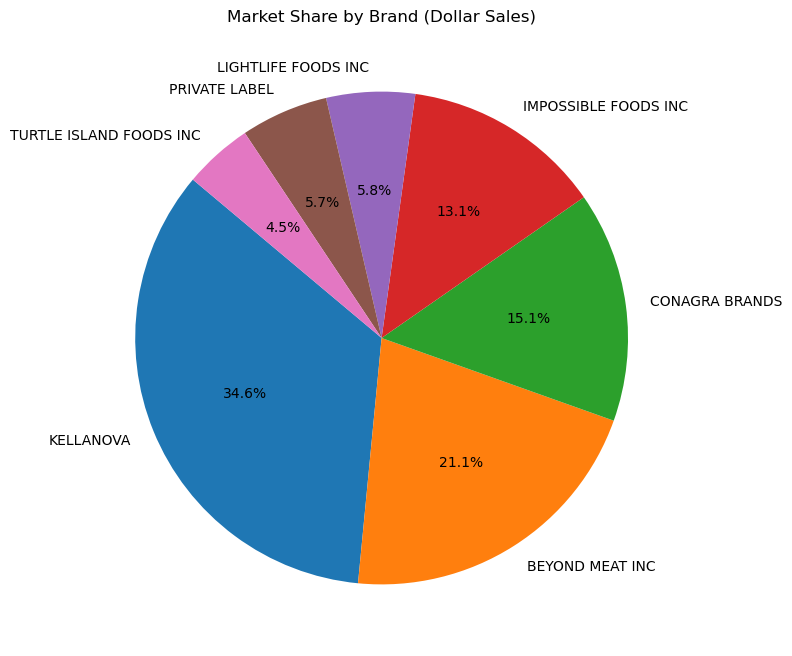

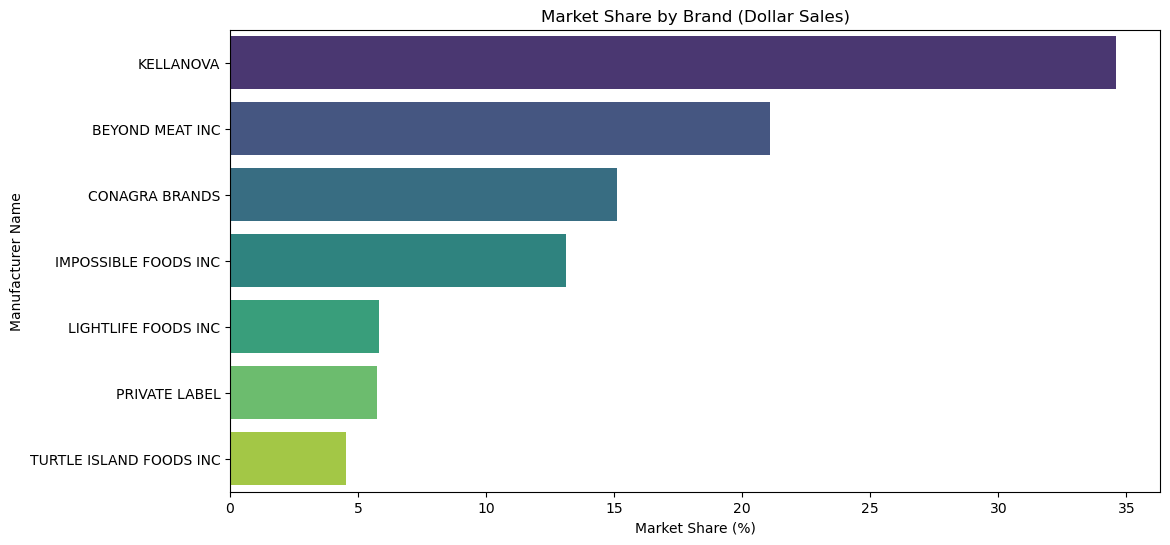

In [9]:
brand_sales = filtered_df.groupby('Manufacturer Name')['Dollar Sales'].sum().reset_index()

total_market_sales = brand_sales['Dollar Sales'].sum()


brand_sales['Market Share (%)'] = (brand_sales['Dollar Sales'] / total_market_sales) * 100
new_brand_sales = brand_sales.sort_values('Market Share (%)', ascending = False).head(10)
brand_sales, total_market_sales
# #Pie Chart for Market Share
plt.figure(figsize=(10, 8))
plt.pie(new_brand_sales['Market Share (%)'], labels=new_brand_sales['Manufacturer Name'], autopct='%1.1f%%', startangle=140)
plt.title('Market Share by Brand (Dollar Sales)')
#plt.show()

#Bar Chart for Market Share
plt.figure(figsize=(12, 6))
sns.barplot(x='Market Share (%)', y='Manufacturer Name', data=new_brand_sales, palette='viridis')
plt.title('Market Share by Brand (Dollar Sales)')
plt.xlabel('Market Share (%)')
plt.ylabel('Manufacturer Name')
plt.show()

## Analysis on Sales Distribution, Focusing on Sales Per Unit

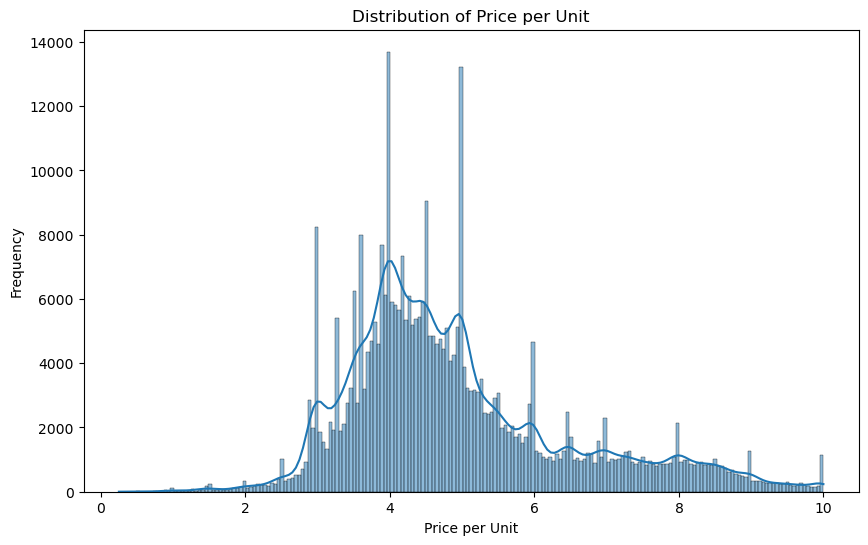

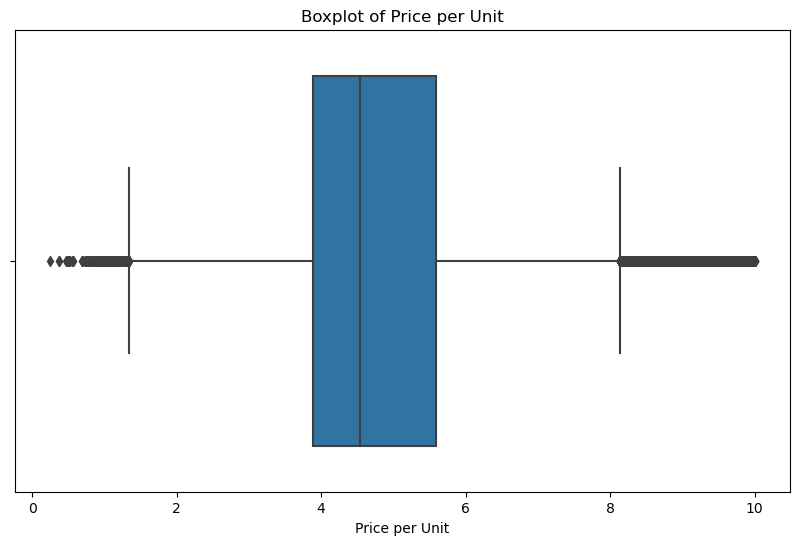

                Price per Unit  Dollar Sales
Price per Unit        1.000000      0.171569
Dollar Sales          0.171569      1.000000


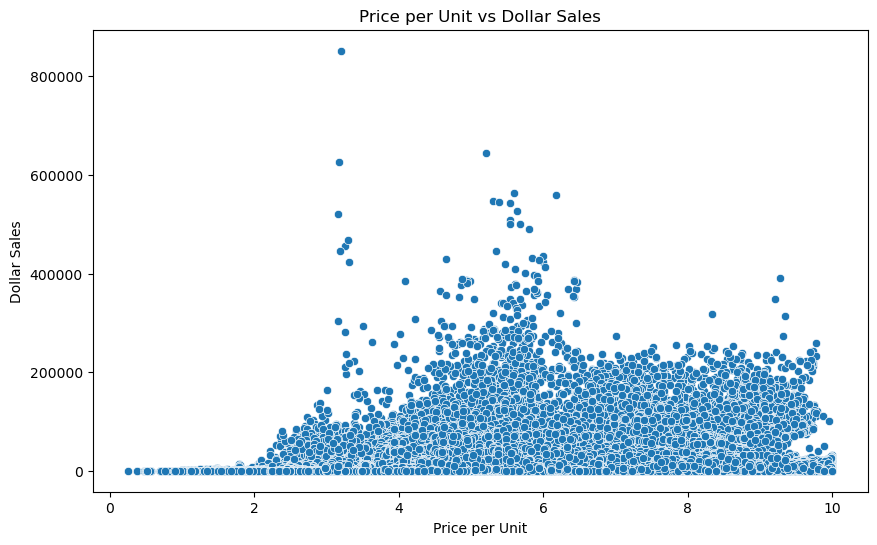

In [10]:
no_outliers_price_descriptive_stats = filtered_df[filtered_df['Price per Unit'] < 10]
price_descriptive_stats = no_outliers_price_descriptive_stats['Price per Unit'].describe()


# Distribution of 'Price per Unit'
plt.figure(figsize=(10, 6))
sns.histplot(no_outliers_price_descriptive_stats['Price per Unit'], kde=True)
plt.title('Distribution of Price per Unit')
plt.xlabel('Price per Unit')
plt.ylabel('Frequency')
plt.show()

# Boxplot for 'Price per Unit'
plt.figure(figsize=(10, 6))
sns.boxplot(x=no_outliers_price_descriptive_stats['Price per Unit'])
plt.title('Boxplot of Price per Unit')
plt.xlabel('Price per Unit')
plt.show()

# Correlation analysis
correlation_matrix = no_outliers_price_descriptive_stats[['Price per Unit', 'Dollar Sales']].corr()
print(correlation_matrix)

# Scatter plot of 'Price per Unit' vs 'Dollar Sales'
plt.figure(figsize=(10, 6))
sns.scatterplot(data=no_outliers_price_descriptive_stats, x='Price per Unit', y='Dollar Sales')
plt.title('Price per Unit vs Dollar Sales')
plt.xlabel('Price per Unit')
plt.ylabel('Dollar Sales')
plt.show()

It's clearly that when price of a product is between (0, 10), the sales reach high point. However, there are several product that has sales above 20, but none of their sales reach to even 1.0*1e6 unit of sales, and there are considered as outliers.
<strong>We can remove them since the amount of outliers, compared to majority of data, is less.<Strong>

## Analysis: Sales by Location

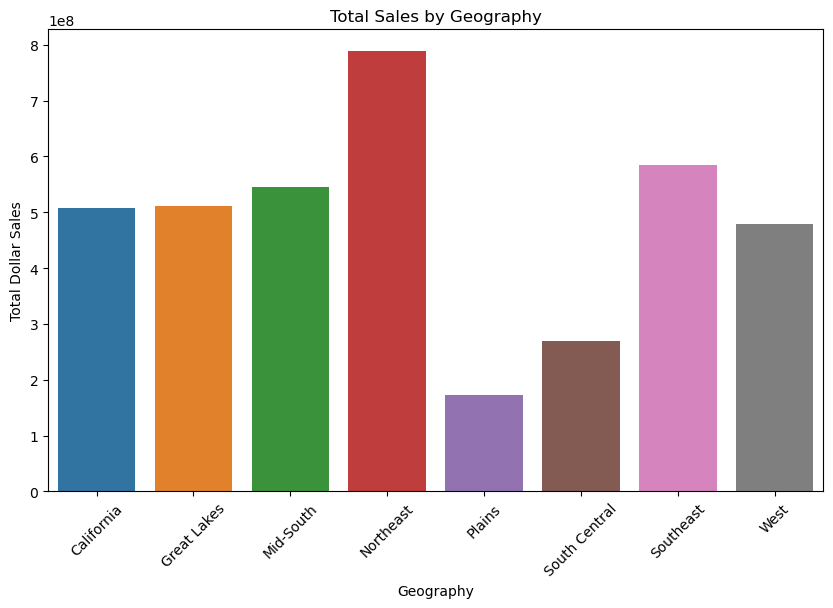

In [11]:
# Geographical Analysis: The 'Geography' column can be used to determine regional preferences or sales performance.
geo_filtered_df = filtered_df[filtered_df['Geography'] != 'Total US']
geo_sales_summary = geo_filtered_df.groupby('Geography')['Dollar Sales'].agg(['sum', 'mean', 'count'])

# Step 2: Visualize Sales by Region
plt.figure(figsize=(10, 6))
sns.barplot(x=geo_sales_summary.index, y=geo_sales_summary['sum'])
plt.title('Total Sales by Geography')
plt.xlabel('Geography')
plt.ylabel('Total Dollar Sales')
plt.xticks(rotation=45)
plt.show()

Pattern:
1. Except mid region of U.S. such as Plains and South Central, all other regions have higher sales of meat alternative, especially in Northeast and Southeast.
2. This Probably because in mid region, people prefer to eat meat
3. It might be associated with slaughter industry

## Analysis: Seasonality

/var/folders/cr/w41p_r656b17sf3g2fyh6wnm0000gn/T/ipykernel_10422/2675719734.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Date'] = pd.to_datetime(filtered_df['Year'].astype(str) + '-' + (filtered_df['Month']).astype(str))
/var/folders/cr/w41p_r656b17sf3g2fyh6wnm0000gn/T/ipykernel_10422/2675719734.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.sort_index(inplace=True)


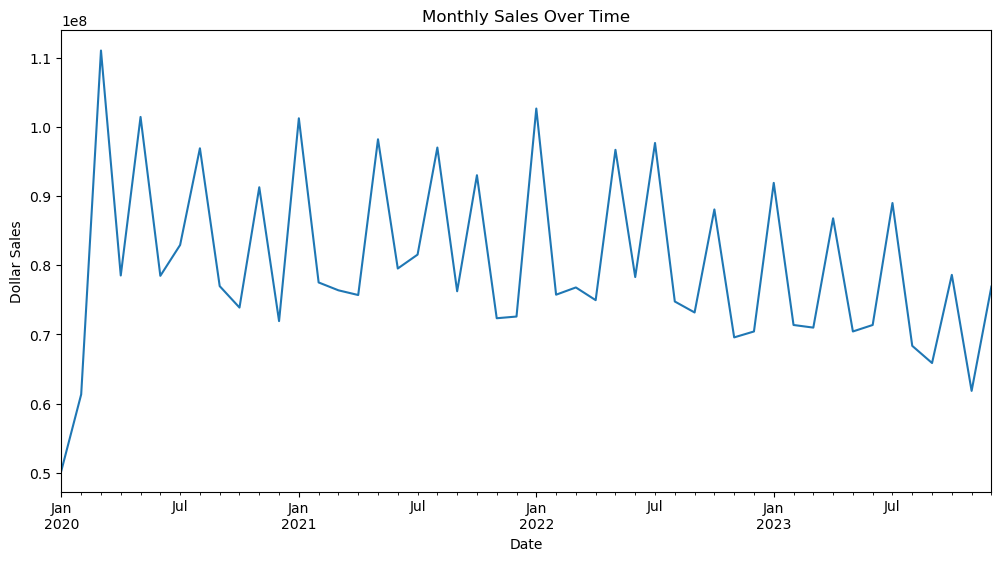

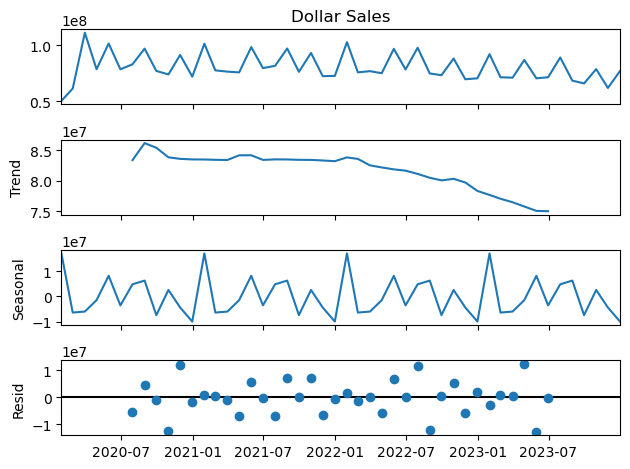

In [12]:
# Time Series Analysis: Use the 'Year', 'Quarter', and 'Month' columns to perform a time series analysis to see sales trends over time.

from statsmodels.tsa.seasonal import seasonal_decompose

# Time Series Analysis: Use the 'Year', 'Quarter', and 'Month' columns to perform a time series analysis to see sales trends over time.
filtered_df['Date'] = pd.to_datetime(filtered_df['Year'].astype(str) + '-' + (filtered_df['Month']).astype(str))

# Step 2: Aggregate Sales Over Time
# Set the date as the index and sort it
filtered_df.set_index('Date', inplace=True)
filtered_df.sort_index(inplace=True)

# Resample the data monthly and sum up the sales
monthly_sales = filtered_df['Dollar Sales'].resample('M').sum()

# Step 3: Visualize Sales Trends
plt.figure(figsize=(12, 6))
monthly_sales.plot(title='Monthly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Dollar Sales')
plt.show()

# Step 4: Decompose the Time Series
result = seasonal_decompose(monthly_sales, model='additive')
result.plot()
plt.show()

## Analysis: Location & Season

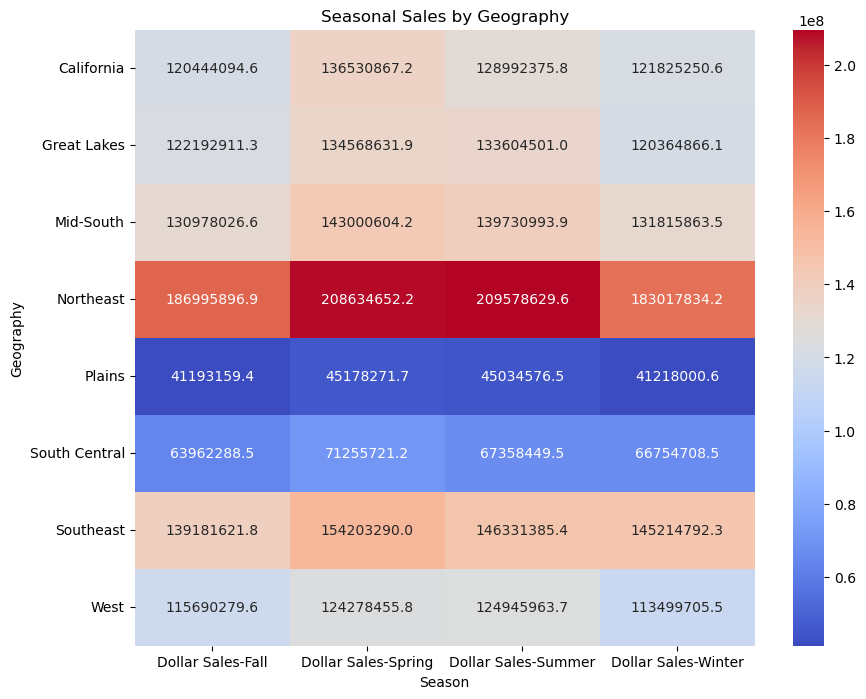

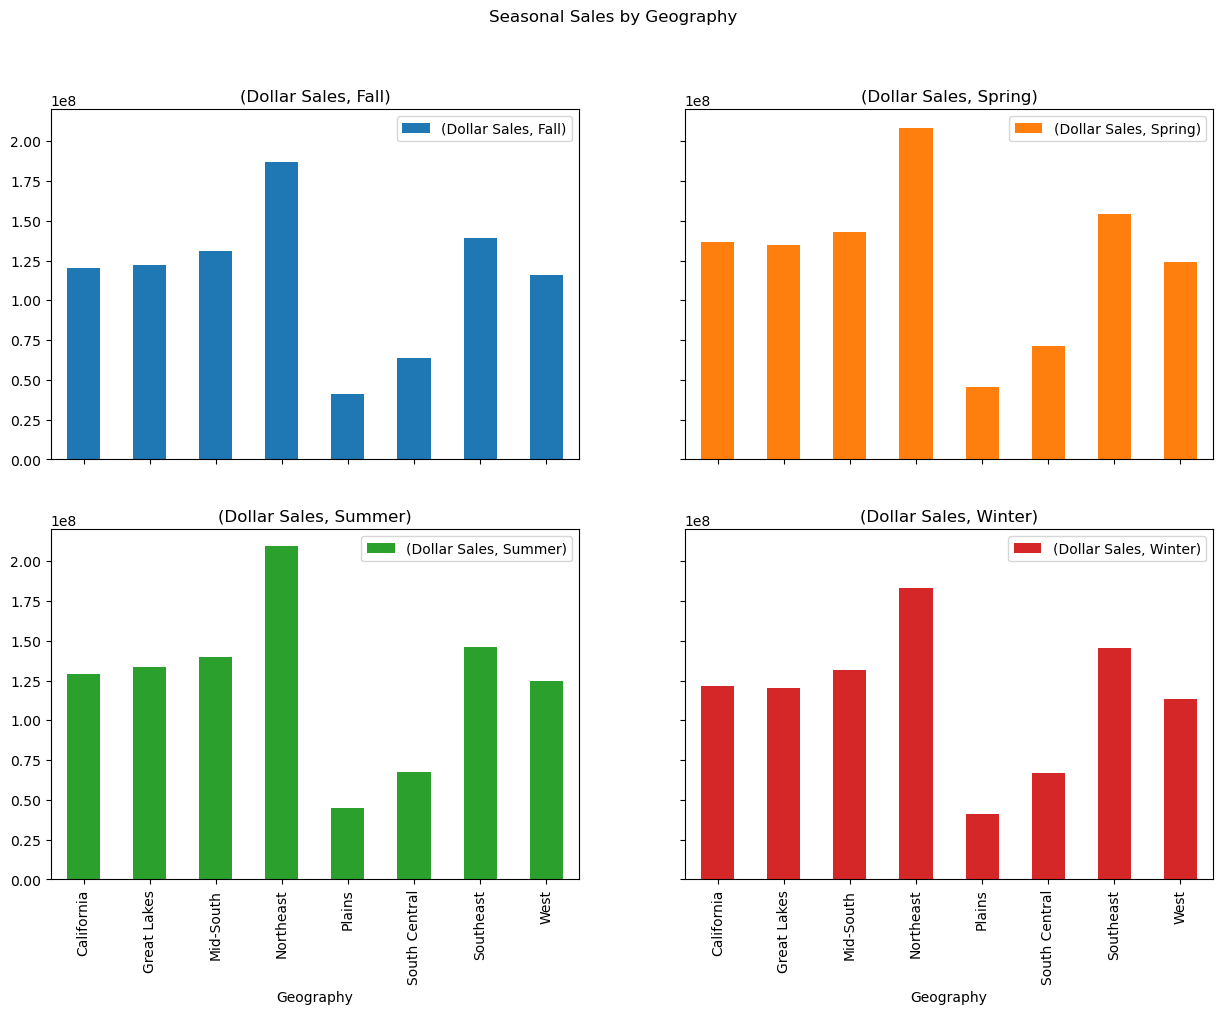

In [13]:
# Filter data
# Step 1: Create a Pivot Table
pivot_table = geo_filtered_df.pivot_table(
    values='Dollar Sales', 
    index=['Geography', 'Season'], 
    aggfunc='sum'
).sort_index()

# Step 2: Visualize Data
# For a simple heatmap:
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table.unstack(level='Season'), cmap='coolwarm', annot=True, fmt=".1f")
plt.title('Seasonal Sales by Geography')
plt.xlabel('Season')
plt.ylabel('Geography')
plt.show()

# For bar charts, if you want to compare seasons across geographies:
pivot_table.unstack().plot(kind='bar', subplots=True, layout=(2,2), figsize=(15, 10), sharey=True)
plt.suptitle('Seasonal Sales by Geography')
plt.show()


Pattern
1. In each year, sales reach to high point and gradually decrease by the time until the end of the year
2. It might because 
    1. Spring produce more vegetables
    2. Hot weather in Summer make people have less appetize
    3. People tend to eat foods with high-energy, high-calories
3. The overall trend of meat alternative sales is in decrease

# Report 2

## Analysis: Product attributes

In [14]:
# Process to calculate distinct products
table_1 = filtered_df.drop_duplicates('Product Name').groupby(['Manufacturer Name', 'Flavor / Scent']).agg({'Product Name':'count'}).reset_index()
table_1

,Manufacturer Name,Flavor / Scent,Product Name
0,BEYOND MEAT INC,BEEF,1
1,BEYOND MEAT INC,BUFFALO,1
2,BEYOND MEAT INC,CHICKEN,2
3,BEYOND MEAT INC,CLASSIC,2
4,BEYOND MEAT INC,FEISTY,1
...,...,...,...
226,TURTLE ISLAND FOODS INC,SESAME GARLIC,1
227,TURTLE ISLAND FOODS INC,SMOKED HAM,1
228,TURTLE ISLAND FOODS INC,SMOKY MAPLE BACON,1
229,TURTLE ISLAND FOODS INC,SPINACH PESTO,1


In [15]:
# Product counts
new_table_1 = table_1.groupby('Manufacturer Name').agg({'Product Name':'sum'}).rename(columns={'Product Name':'Product Counts'}).reset_index()
new_table_1

,Manufacturer Name,Product Counts
0,BEYOND MEAT INC,33
1,CONAGRA BRANDS,62
2,IMPOSSIBLE FOODS INC,19
3,KELLANOVA,99
4,LIGHTLIFE FOODS INC,40
5,PRIVATE LABEL,174
6,TURTLE ISLAND FOODS INC,28


In [16]:
# Transaction counts
table_2 = filtered_df.groupby(['Manufacturer Name']).agg({'Product Name':'count'}).rename(columns={'Product Name':'Transaction Records'}).reset_index()
table_2

,Manufacturer Name,Transaction Records
0,BEYOND MEAT INC,28021
1,CONAGRA BRANDS,63815
2,IMPOSSIBLE FOODS INC,18490
3,KELLANOVA,87320
4,LIGHTLIFE FOODS INC,41542
5,PRIVATE LABEL,111025
6,TURTLE ISLAND FOODS INC,33157


<strong>Kellanova is the manufacturer name for all its morningstar series products, while Conagra brans is the manufactuer name for all Gardein products.
In the range of top 3 companies, by this table, we can tell that there are extremly huge difference between amount of product. Kellanova > Conagra > Impossible. The advantage of wide varity in products leads to more buyer records. Kellanova > Conagra > Impossible. However, manufacturer 'Private Lable' actually has more transaction orders than any rest of them, its sales ranking is only NO.6<strong>
    


## Grouping by Flavor, Ranking by Product & Sales

In [17]:
table_3 = filtered_df.drop_duplicates('Product Name').groupby(['Manufacturer Name', 'Flavor / Scent']).agg({'Product Name':'count'})
table_3['total sales'] = filtered_df.groupby(['Manufacturer Name', 'Flavor / Scent']).agg({'Dollar Sales':'sum'})
table_3['product_rank'] = table_3['Product Name'].rank(ascending = False, method = 'first')
table_3['sales_rank'] = table_3['total sales'].rank(ascending = False, method = 'first')
table_3 = table_3.reset_index()

In [18]:
# Flavor checking
table_3.groupby(['Manufacturer Name']).agg({'Flavor / Scent': 'count'})

,Flavor / Scent
Manufacturer Name,
BEYOND MEAT INC,12
CONAGRA BRANDS,30
IMPOSSIBLE FOODS INC,9
KELLANOVA,50
LIGHTLIFE FOODS INC,20
PRIVATE LABEL,86
TURTLE ISLAND FOODS INC,24


In [19]:
table_3.sort_values('sales_rank').head(50)

,Manufacturer Name,Flavor / Scent,Product Name,total sales,product_rank,sales_rank
8,BEYOND MEAT INC,REGULAR,14,5.168296e+08,3.0,1.0
47,IMPOSSIBLE FOODS INC,REGULAR,2,3.541446e+08,41.0,2.0
30,CONAGRA BRANDS,REGULAR,21,2.635928e+08,2.0,3.0
74,KELLANOVA,ORIGINAL,10,1.780601e+08,6.0,4.0
78,KELLANOVA,REGULAR,14,1.415592e+08,4.0,5.0
85,KELLANOVA,SPICY BLACK BEAN,2,1.142970e+08,49.0,6.0
94,KELLANOVA,VEGETABLE GRILLER ORIGINAL,2,9.887688e+07,50.0,7.0
75,KELLANOVA,ORIGINAL SAUSAGE,1,9.760778e+07,105.0,8.0
51,KELLANOVA,BACON,2,9.601983e+07,43.0,9.0
16,CONAGRA BRANDS,CHICKEN,5,9.028066e+07,10.0,10.0


All these companies make profit most from regular / original / chicken products. However, with over 60+ products and 30 flavors from Conagra, it still cannot beat IMPOSSIBLE on marketing.

Which is because
1. Only 4 products from Conagra are in top 20. 
2. IMPOSSIBLE are making more profit from their 22 products of 9 flavors, which indicates that IMPOSSIBLE beats Conagra from
    1. Products Quality (Flavor, Size)
    2. IMPOSSBLE might have a better marketing strategy such as advertisement deployment than conagra

Reason for Conagra cannot beat Kellanova might be:
1. 18 products from Kellanova are in the top 20 from the list of sales
2. kellanova has more flavors(48) & products(96) than conagra (30, 65)

According to table1 to table 3, suggestions could be:
1. Develop more flavor
2. Provide more options for single product, especially for regular flavor

Reasons might for regular flavor products has most sales might be:
1. people like to season it later based on their preference
2. flavor adjusted by manufacturer is just terrible

## What products should Conagra publish in the future?

In [20]:
recent_time_filtered_df = filtered_df[filtered_df['Year'] >= 2022]
past_time_filtered_df = filtered_df[filtered_df['Year'] < 2022]['Product Name']
time_product_filtered_df = recent_time_filtered_df[~recent_time_filtered_df['Product Name'].isin(past_time_filtered_df)]
time_product_filtered_df = time_product_filtered_df[['Year', 'Manufacturer Name', 'Product Name','Flavor / Scent', 'Dollar Sales']]
time_product_filtered_df = time_product_filtered_df.drop_duplicates('Product Name').sort_values('Dollar Sales', ascending = False) #table 4
temp = time_product_filtered_df[time_product_filtered_df['Manufacturer Name'] != 'CONAGRA BRANDS'].sort_values('Manufacturer Name')
temp

,Year,Manufacturer Name,Product Name,Flavor / Scent,Dollar Sales
Date,,,,,
2022-01-01,2022,BEYOND MEAT INC,FROZEN REGULAR MEAT SUBSTITUTE PATTY 39.8 OZ,REGULAR,21783.340000
2022-12-01,2022,BEYOND MEAT INC,FROZEN REGULAR PLANT BASED CHICKEN SUBSTITUTE ...,REGULAR,1198.713054
2022-09-01,2022,BEYOND MEAT INC,FROZEN CHICKEN PLANT BASED CHICKEN SUBSTITUTE ...,CHICKEN,616.681171
2023-05-01,2023,BEYOND MEAT INC,FROZEN SPICY MEAT SUBSTITUTE PATTY 11 OZ,SPICY,323.062024
2023-07-01,2023,BEYOND MEAT INC,FROZEN ORIGINAL MEAT SUBSTITUTE PATTY 15 OZ,ORIGINAL,3657.893260
...,...,...,...,...,...
2022-09-01,2022,PRIVATE LABEL,FROZEN TERIYAKI PLANT BASED CHICKEN SUBSTITUTE...,TERIYAKI,102.081830
2022-09-01,2022,PRIVATE LABEL,FROZEN GENERAL TSOS POULTRY SUBSTITUTE 9.5 OZ,GENERAL TSOS,70.205088
2022-09-01,2022,PRIVATE LABEL,FROZEN BREAKFAST SAUSAGE MEAT SUBSTITUTE PATTY...,BREAKFAST SAUSAGE,4.231667


### Baby Step to KELLANOVA

/var/folders/cr/w41p_r656b17sf3g2fyh6wnm0000gn/T/ipykernel_10422/1985285584.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['Period'] = temp_df['Year'].astype(str) + ' Q' + temp_df['Quarter'].astype(str)


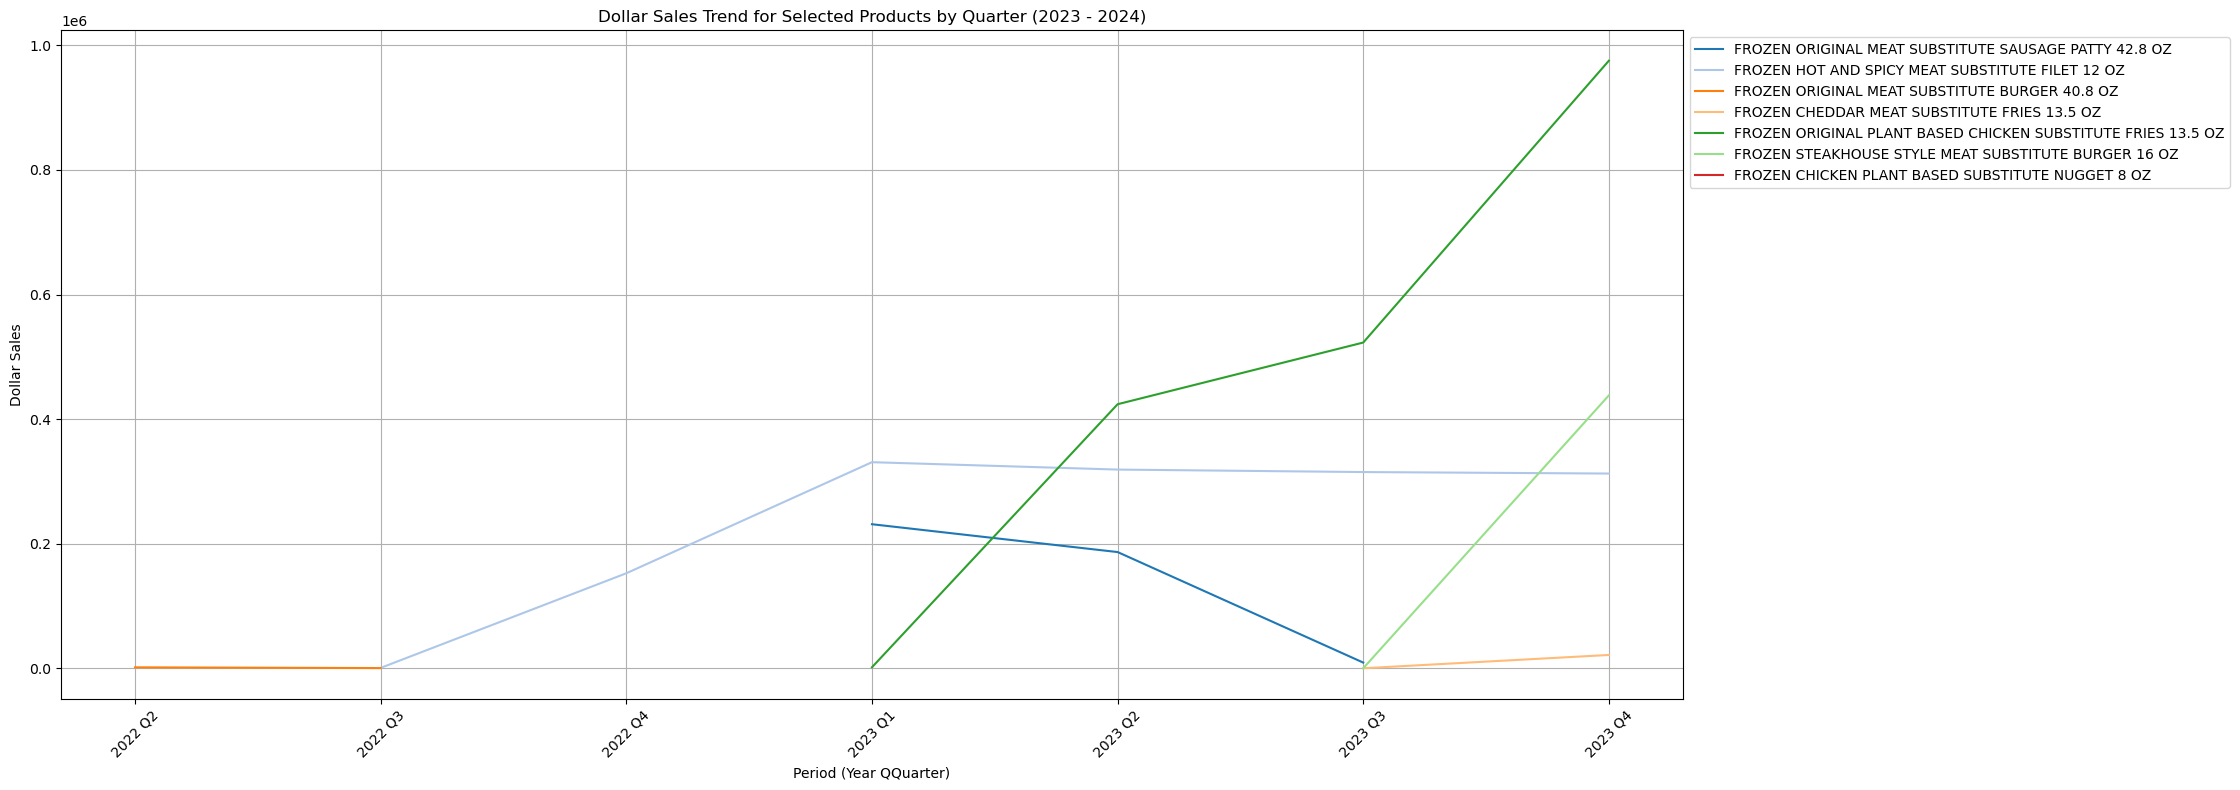

In [21]:
temp = time_product_filtered_df[time_product_filtered_df['Manufacturer Name'] == 'KELLANOVA'].sort_values('Manufacturer Name')
#temp = time_product_filtered_df[time_product_filtered_df['Manufacturer Name'] == 'IMPOSSIBLE FOODS INC'].sort_values('Manufacturer Name')
temp_df = filtered_df
temp_df['Period'] = temp_df['Year'].astype(str) + ' Q' + temp_df['Quarter'].astype(str)

products_of_interest = temp['Product Name']

product_filtered_df = temp_df[filtered_df['Product Name'].isin(products_of_interest)]

# Aggregate 'Dollar Sales' by 'Year' and 'Product Name'
aggregated_df = product_filtered_df.groupby(['Period', 'Product Name']).agg({'Dollar Sales': 'sum'}).reset_index()

# Pivot the DataFrame to have 'Product Name' as columns, 'Year' as the index, and 'Dollar Sales' as values
pivoted_df = aggregated_df.pivot(index='Period', columns='Product Name', values='Dollar Sales')
pivoted_df



# Create a color palette with a unique color for each product
color_palette = plt.cm.tab20(np.linspace(0, 1, 20))
plt.figure(figsize=(30, 8))
for i, product in enumerate(products_of_interest):
    plt.plot(pivoted_df.index, pivoted_df[product], label=product, color=color_palette[i])

plt.title('Dollar Sales Trend for Selected Products by Quarter (2023 - 2024)')
plt.xlabel('Period (Year QQuarter)')
plt.ylabel('Dollar Sales')
plt.xticks(rotation=45)

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout(rect=[0, 0, 0.75, 1])
plt.show()

/var/folders/cr/w41p_r656b17sf3g2fyh6wnm0000gn/T/ipykernel_10422/1985285584.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['Period'] = temp_df['Year'].astype(str) + ' Q' + temp_df['Quarter'].astype(str)


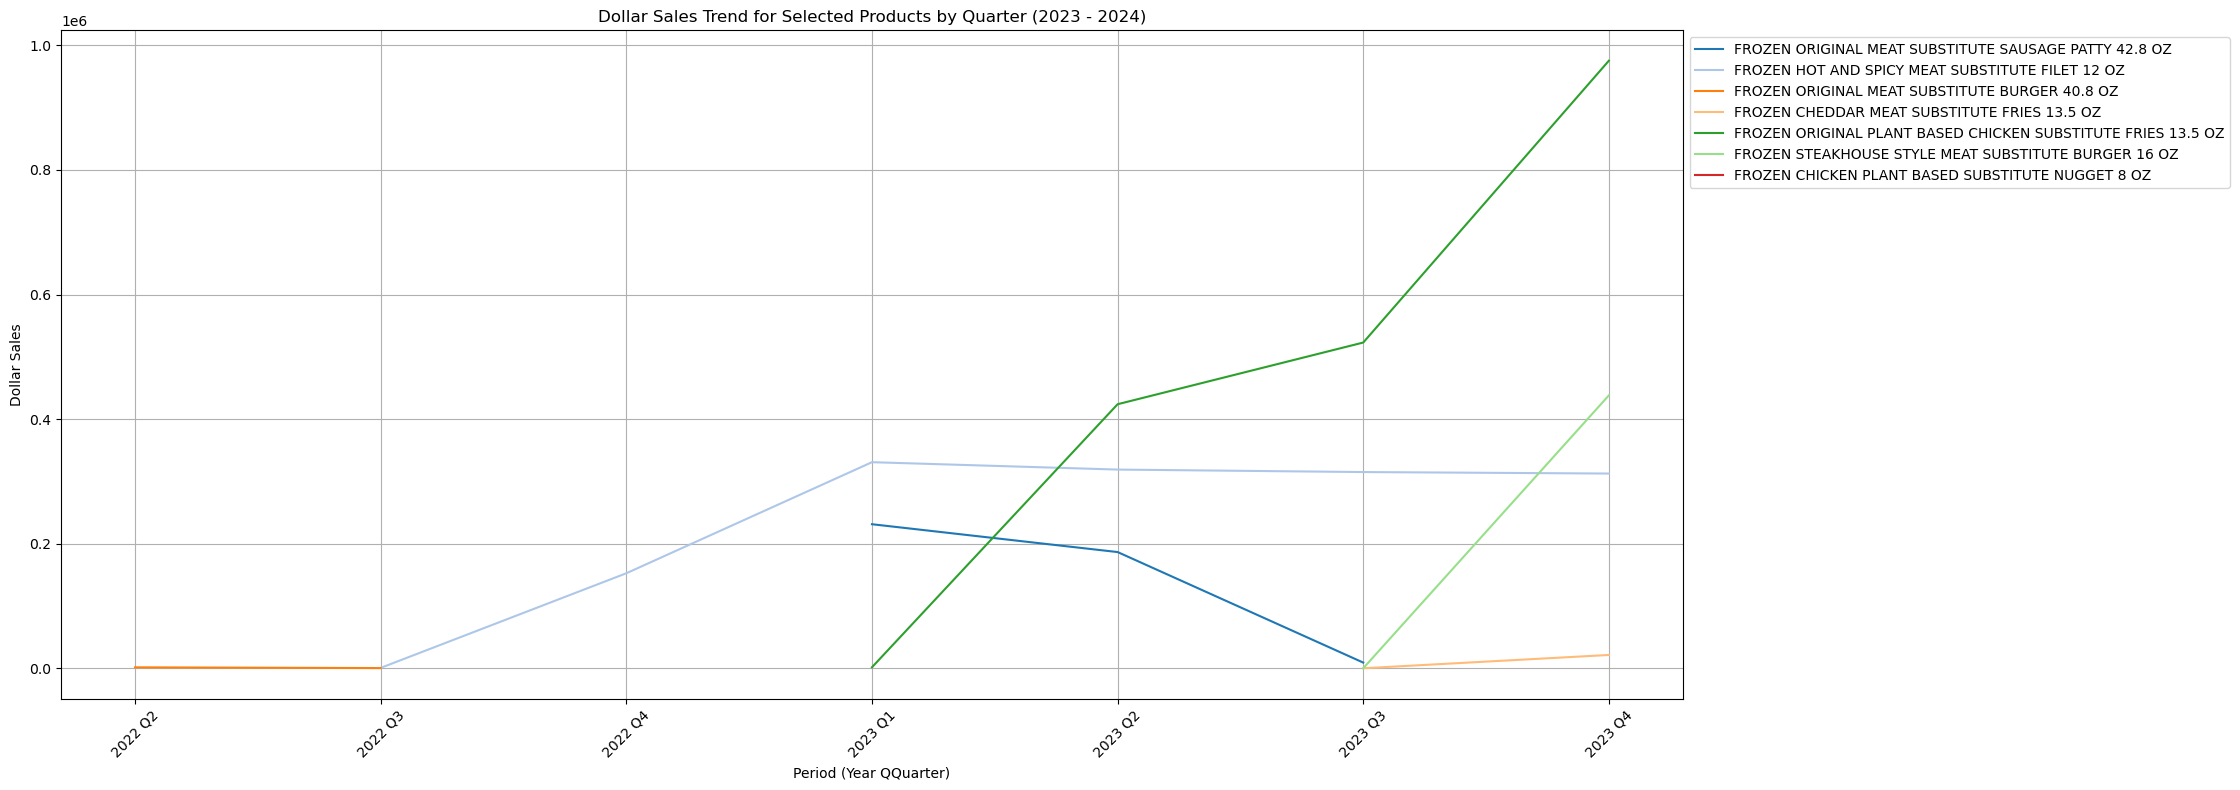

In [23]:
temp = time_product_filtered_df[time_product_filtered_df['Manufacturer Name'] == 'KELLANOVA'].sort_values('Manufacturer Name')
#temp = time_product_filtered_df[time_product_filtered_df['Manufacturer Name'] == 'IMPOSSIBLE FOODS INC'].sort_values('Manufacturer Name')
temp_df = filtered_df
temp_df['Period'] = temp_df['Year'].astype(str) + ' Q' + temp_df['Quarter'].astype(str)

products_of_interest = temp['Product Name']

product_filtered_df = temp_df[filtered_df['Product Name'].isin(products_of_interest)]

# Aggregate 'Dollar Sales' by 'Year' and 'Product Name'
aggregated_df = product_filtered_df.groupby(['Period', 'Product Name']).agg({'Dollar Sales': 'sum'}).reset_index()

# Pivot the DataFrame to have 'Product Name' as columns, 'Year' as the index, and 'Dollar Sales' as values
pivoted_df = aggregated_df.pivot(index='Period', columns='Product Name', values='Dollar Sales')
pivoted_df



# Create a color palette with a unique color for each product
color_palette = plt.cm.tab20(np.linspace(0, 1, 20))
plt.figure(figsize=(30, 8))
for i, product in enumerate(products_of_interest):
    plt.plot(pivoted_df.index, pivoted_df[product], label=product, color=color_palette[i])

plt.title('Dollar Sales Trend for Selected Products by Quarter (2023 - 2024)')
plt.xlabel('Period (Year QQuarter)')
plt.ylabel('Dollar Sales')
plt.xticks(rotation=45)

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout(rect=[0, 0, 0.75, 1])
plt.show()

Things than can conlude from table 4 & visualization above:
1. 21 new plant-based products were published since 2022. (Doesn't include new products from Conagra)
2. IMPOSSIBLE Products:

    Top 3 products (from IMPOSSIBLE) that sales most are:
    
        1. FROZEN REGULAR POULTRY SUBSTITUTE PATTY 14 OZ
        2. FROZEN CHECK PLANT BASED CHICKEN SUBSTITUTE NUGGEST 32 OZ
        3. REFRIGERATED BRATWURST MEAT SUBSTITUTE LINK 13.5 OZ  
        
    Especially for FROZEN REGULAR POULTRY SUBSTITUTE PATTY, by the time it's released, its sales performance goes like a rocket<p></p>
    For FROZEN ORIGINAL PLANT BASED CHICKEN SUBSTITUTE FRIES & FROZEN STEAKHOUSE STYLE MEAT SUBSTITUTE BURGER, though it's released since 2023 Q1 and 2023 Q3, the plot shows more people would like to buy them as its sales present a 45 degree upword trend
    
3. KELLANOVA Products:
    Considerable Products: FROZEN PRIGINAL MEAT SUBSTITUTE SAUSAGE PATTY 42.8 OZ
    The rest of it, from my opinions, do not deserve.
    
4. Conagra should give products with sales below 2.0 and don't present a upword trend a try

Conclusion: <p>
It's not hard to tell that each single new product that sells best at least has the following attribtues:
1. Chicken flavor based
2. Simple seasoning or no seasoning (regular flavor)
3. Substitution for fast food or foods that generally have high calories such as fries, patty
4. This doesn't indicate Conagra should complete copy what competitors do, instead, it should learn from them and develop a "Conagra-made" product
</p>

### Mapping Package Size & Product Name & Flavor

In [29]:
def extract_size(row):
    return row.split(' ')[-2]

def map_size_into_text(row):
    if row <= 12:
        return 'Small'
    elif row >= 18:
        return 'Large'
    else:
        return 'Medium'
    
def map_product_name(row):
    if 'FROZEN' in row:
        if 'MEAT' in row:
            return 'FROZEN MEAT'
        elif 'FISH' in row:
            return 'FROZEN FISH'
        elif 'SEAFOOD' in row:
            return 'FROZEN SEAFOOD'
        elif 'FALAFEL' in row:
            return 'FROZEN FALAFEL'
        elif 'POULTRY' in row:
            return 'FROZEN POULTRY'
        elif 'CHICKEN' in row:
            return 'FROZEN CHICKEN'
        else:
            return 'FROZEN MEAT ALTERNATIVE'
    elif 'REFRIGERATED' in row:
        if 'MEAT' in row and 'SAUSAGE' not in row:
            return 'REFRIGERATED MEAT'
        elif 'SAUSAGE' in row:
            return 'REFRIGERATED SAUSAGE'
        else:
            return 'REFRIGERATED MEAT ALTERNATIVE'
    else:
        return 'FROZEN POULTRY'
    
def map_flavor(row):
    if 'CHICK' in row or 'CHICKEN' in row or 'TURKEY' in row:
        return 'CHICKEN'
    elif 'SPICY' in row or 'HOT' in row or 'BUFFALO' in row or 'SIZZLING SZECHUAN' in row or 'FEISTY' in row or 'PEPPER' in row or 'CAJUN' in row or 'JALAPENO' in row or 'MASALA' in row or 'PEPPADEW' in row or 'GARLIC' in row or 'TEX MEX' in row or 'GINGER' in row or 'SWEDISH' in row or 'SOUTH' in row or 'WEST' in row or 'STYLE' in row or 'MEXICAN' in row or 'THAI' in row or 'ASIAN' in row:
        return 'SPICY'
    elif 'BARBEQUE' in row or 'SMOKED' in row or 'SMOKY' in row or 'GRILLED' in row:
        return 'BARBEQUE'
    elif 'REGULAR' in row or 'ORIGINAL' in row or 'CLASSIC' in row or 'HOMESTYLE' in row or 'SALT' in row or 'TRADITION' in row or 'ULTIMATE' in row or 'JUICY' in row or 'BEAN' in row or 'LENTIL' in row or 'PINTO' in row or 'HARVEST' in row or 'GRAIN' in row or 'ROAST' in row or 'QUINOA' in row or 'FLAX' in row:
        return 'REGULAR'
    elif 'BEEF' in row or 'STEAK' in row or 'BURGER' in row:
        return 'BEEF'
    elif 'VEGETABLE' in row or 'GARDEN' in row or 'KALE' in row or 'PESTO' in row or 'BEET' in row or 'MUSHROOM' in row or 'PORTABELLO' in row:
        return 'VEGETABLE'
    elif 'CHORIZO' in row or 'BACON' in row or 'PORK' in row or 'HAM' in row or 'SAUSAGE' in row or 'KIELBASA' in row or 'BOLOGNA' in row or 'BRATWURST' in row or 'MEAT LOVERS' in row:
        return 'PORK'
    elif 'MAPLE' in row or 'SWEET' in row or 'TERIYAKI' in row or 'SAVORY' in row or 'CHEDDAR' in row or 'BEER' in row:
        return 'SWEET'
    elif 'RANCH' in row or 'LIME' in row or 'SOUR' in row or 'ORANGE' in row or 'BUTTERMILK' in row or 'GENERAL TSOS' in row or 'CHIPOTLE' in row or 'ITALIAN' in row or 'PIZZA' in row or 'HERB' in row or 'BASIL' in row or 'FALAFEL' in row:
        return 'SOUR'
    else:
        return row

# Tried to narrow down further. Giner, garlic can be considered as spicy, asian, that, could be also considered as spicy.
# 4 major cluster: spicy, sweet, bbq, other

In [30]:
filtered_df['Package Size'] = filtered_df['Product Name'].apply(extract_size)
filtered_df['Package Size'] = filtered_df['Package Size'].astype(float)
filtered_df['Portion'] = filtered_df['Package Size'].apply(map_size_into_text)
filtered_df['Category'] = filtered_df['Product Name'].apply(map_product_name)
filtered_df['Flavor / Scent'] = filtered_df['Flavor / Scent'].apply(map_flavor)

/var/folders/cr/w41p_r656b17sf3g2fyh6wnm0000gn/T/ipykernel_10422/2956242602.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Package Size'] = filtered_df['Product Name'].apply(extract_size)
/var/folders/cr/w41p_r656b17sf3g2fyh6wnm0000gn/T/ipykernel_10422/2956242602.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Package Size'] = filtered_df['Package Size'].astype(float)
/var/folders/cr/w41p_r656b17sf3g2fyh6wnm0000gn/T/ipykernel_10422/2956242602.py:3: SettingWithCopyWarning: 

## Analysis: Package Size Impact

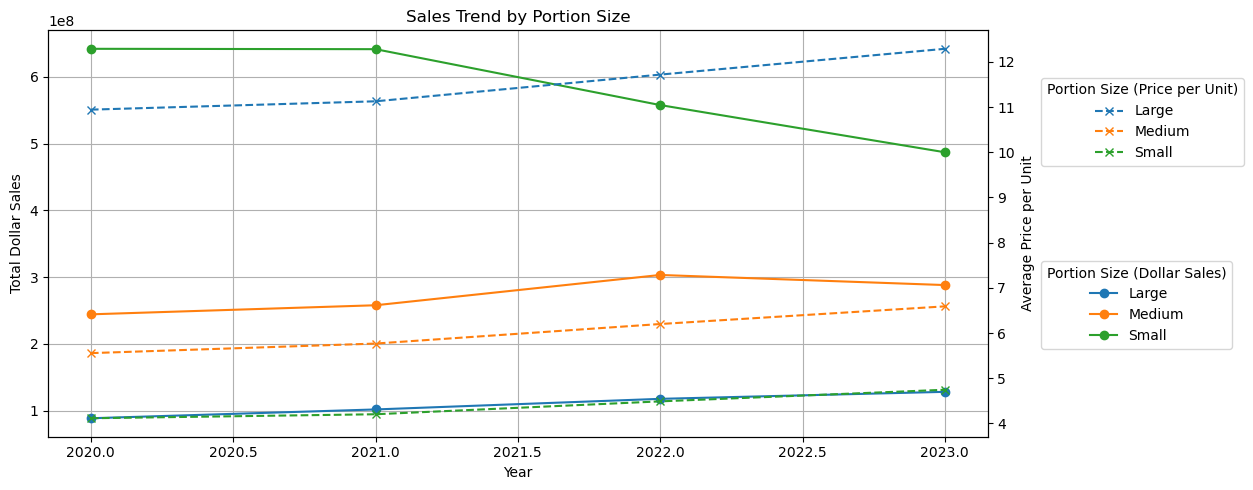

In [26]:
# Group the data by 'Year' and 'Portion' and get the sum of 'Dollar_Sales' and 'Unit_Sales'
grouped_data = filtered_df.groupby(['Year', 'Portion']).agg({
    'Dollar Sales': 'sum',
    'Price per Unit': 'mean'
}).reset_index()

# Pivot the data to have years as the index and portion sizes as columns for each sales type
pivot_dollar_sales = grouped_data.pivot(index='Year', columns='Portion', values='Dollar Sales')
pivot_unit_sales = grouped_data.pivot(index='Year', columns='Portion', values='Price per Unit')

# Create the first plot with 'Dollar_Sales'
fig, ax1 = plt.subplots(figsize=(15, 5))

line1 = pivot_dollar_sales.plot(kind='line', marker='o', ax=ax1)
ax1.set_title('Sales Trend by Portion Size')
ax1.set_xlabel('Year')
ax1.set_ylabel('Total Dollar Sales')
ax1.grid(True)

# Create a secondary y-axis for 'Unit_Sales'
ax2 = ax1.twinx()
line2 = pivot_unit_sales.plot(kind='line', marker='x', ax=ax2, linestyle='--')
ax2.set_ylabel('Average Price per Unit')

# Place the legend for 'Dollar_Sales' on the right side outside the plot
ax1.legend(title='Portion Size (Dollar Sales)', loc='upper left', bbox_to_anchor=(1.05, 0.45))

# Place the legend for 'Unit_Sales' below the first legend
ax2.legend(title='Portion Size (Price per Unit)', loc='upper left', bbox_to_anchor=(1.05, 0.90))

# Adjust layout to make room for the legend
plt.tight_layout(rect=[0, 0, 0.85, 1])

# Display the plot
plt.show()


Pattern(Sales):
1. Altough small size sales present downword trend, it's still selling most
2. Medium size has a obvious upword trend since 2021
3. Large size slightly increase by time, yet still it didn't sell that much

Pattern(Price per Unit):
1. just based on the plot, the price per unit difference between small & medium are approximately 3 dollars, while it's 5 or 6 dollars between small & large.
2. People starting buying more medium size products as small size sales present a downword trend, though the price per unit is getting higher
    1. maybe people find it's more cost-effective to buy medium size
    2. maybe people getting used to plant-based products, it's turning "i will give it a try" to "it's nice, let's take it as our dinner/luncher"

Conclusion:
1. it should focus on small and medium size portion when Conagra publish new products
2. Price for small & medium size products are more attractive and cost less. Will highly increase the probability of "making the first purchase"
3. For large-size products, the gradually increasing sales also reflect people's demand for one product. It may appropriate to consider publish some other products in large size (ex. medium size products that sell particularly well)

## Analysis: Return Buyer

In [99]:
bb_df = pd.read_excel('/Users/fuqiaozhi/Desktop/UTD Semesters/Spring 2024/BUAN 6337/Conagra Cleaned Data/Panel_HH Buying.xlsx')

In [100]:
filtered_bb_df = bb_df[bb_df['Product'].str.contains('SUBSTITUTE')].dropna()
filtered_bb_df.rename(columns = {'52 Weeks Ending Jan-28-2024 % HHs Buying 2x+': '2024 Week 1 2x+',
                                '52 Weeks Ending Jan-28-2024 % HHs Buying 1x': '2024 Week 1 1x',
                                '52 Weeks Ending Jan-28-2024 % HH Buying': '2024 Week 1',
                                '52 Weeks Ending Jan-29-2023 % HHs Buying 2x+': '2023 Week 1 2x+',
                                '52 Weeks Ending Jan-29-2023 % HHs Buying 1x': '2023 Week 1 1x',
                                '52 Weeks Ending Jan-29-2023 % HH Buying': '2023 Week 1',
                                '52 Weeks Ending Jan-30-2022 % HHs Buying 2x+': '2022 Week 1 2x+',
                                '52 Weeks Ending Jan-30-2022 % HHs Buying 1x': '2022 Week 1 1x',
                                '52 Weeks Ending Jan-30-2022 % HH Buying': '2022 Week 1',
                                '52 Weeks Ending Jan-30-2022 Standard Hierarchy Level': 'Hierarchy'}, inplace=True)
filtered_bb_df = filtered_bb_df[filtered_bb_df['Hierarchy'] == 'SubCategory']
filtered_bb_df.drop(columns = ['Geography', 'Hierarchy'], inplace = True)
filtered_bb_df

,Product,2022 Week 1,2022 Week 1 1x,2022 Week 1 2x+,2023 Week 1,2023 Week 1 1x,2023 Week 1 2x+,2024 Week 1,2024 Week 1 1x,2024 Week 1 2x+
17,FZ MEAT SUBSTITUTES,13.213465,5.522439,7.691025,12.204339,5.237158,6.967180,9.933331,4.169280,5.764052
18,FZ POULTRY SUBSTITUTE,6.196199,2.776944,3.419255,5.838505,2.577777,3.260728,4.728191,2.082754,2.645437
19,PROCESSED FZ POULTRY SUBSTITUTE,3.124632,1.913912,1.210720,4.013782,2.197045,1.816737,2.999120,1.515419,1.483701
20,PROCESSED RFG POULTRY SUBSTITUTE,0.728380,0.495606,0.232774,0.686572,0.403127,0.283446,0.452968,0.281451,0.171517
21,RFG MEAT SUBSTITUTES,10.589058,4.474305,6.114753,8.317554,3.486492,4.831061,6.699186,2.929267,3.769919
22,RFG POULTRY SUBSTITUTE,0.619837,0.439062,0.180775,0.501559,0.330008,0.171551,0.310647,0.204753,0.105894


In [101]:
def add_three_weeks(row, year, week1_suffix, week2_suffix, week3_suffix):
    week1_column = f"{year} Week {week1_suffix}"
    week2_column = f"{year} Week {week2_suffix}"
    week3_column = f"{year} Week {week3_suffix}"
    return row[week1_column] + row[week2_column] + row[week3_column]


In [102]:
filtered_bb_df['2022 Weeks'] = filtered_bb_df.apply(lambda row: add_three_weeks(row, '2022', '1', '1 1x', '1 2x+'), axis=1)
filtered_bb_df['2023 Weeks'] = filtered_bb_df.apply(lambda row: add_three_weeks(row, '2023', '1', '1 1x', '1 2x+'), axis=1)
filtered_bb_df['2024 Weeks'] = filtered_bb_df.apply(lambda row: add_three_weeks(row, '2024', '1', '1 1x', '1 2x+'), axis=1)

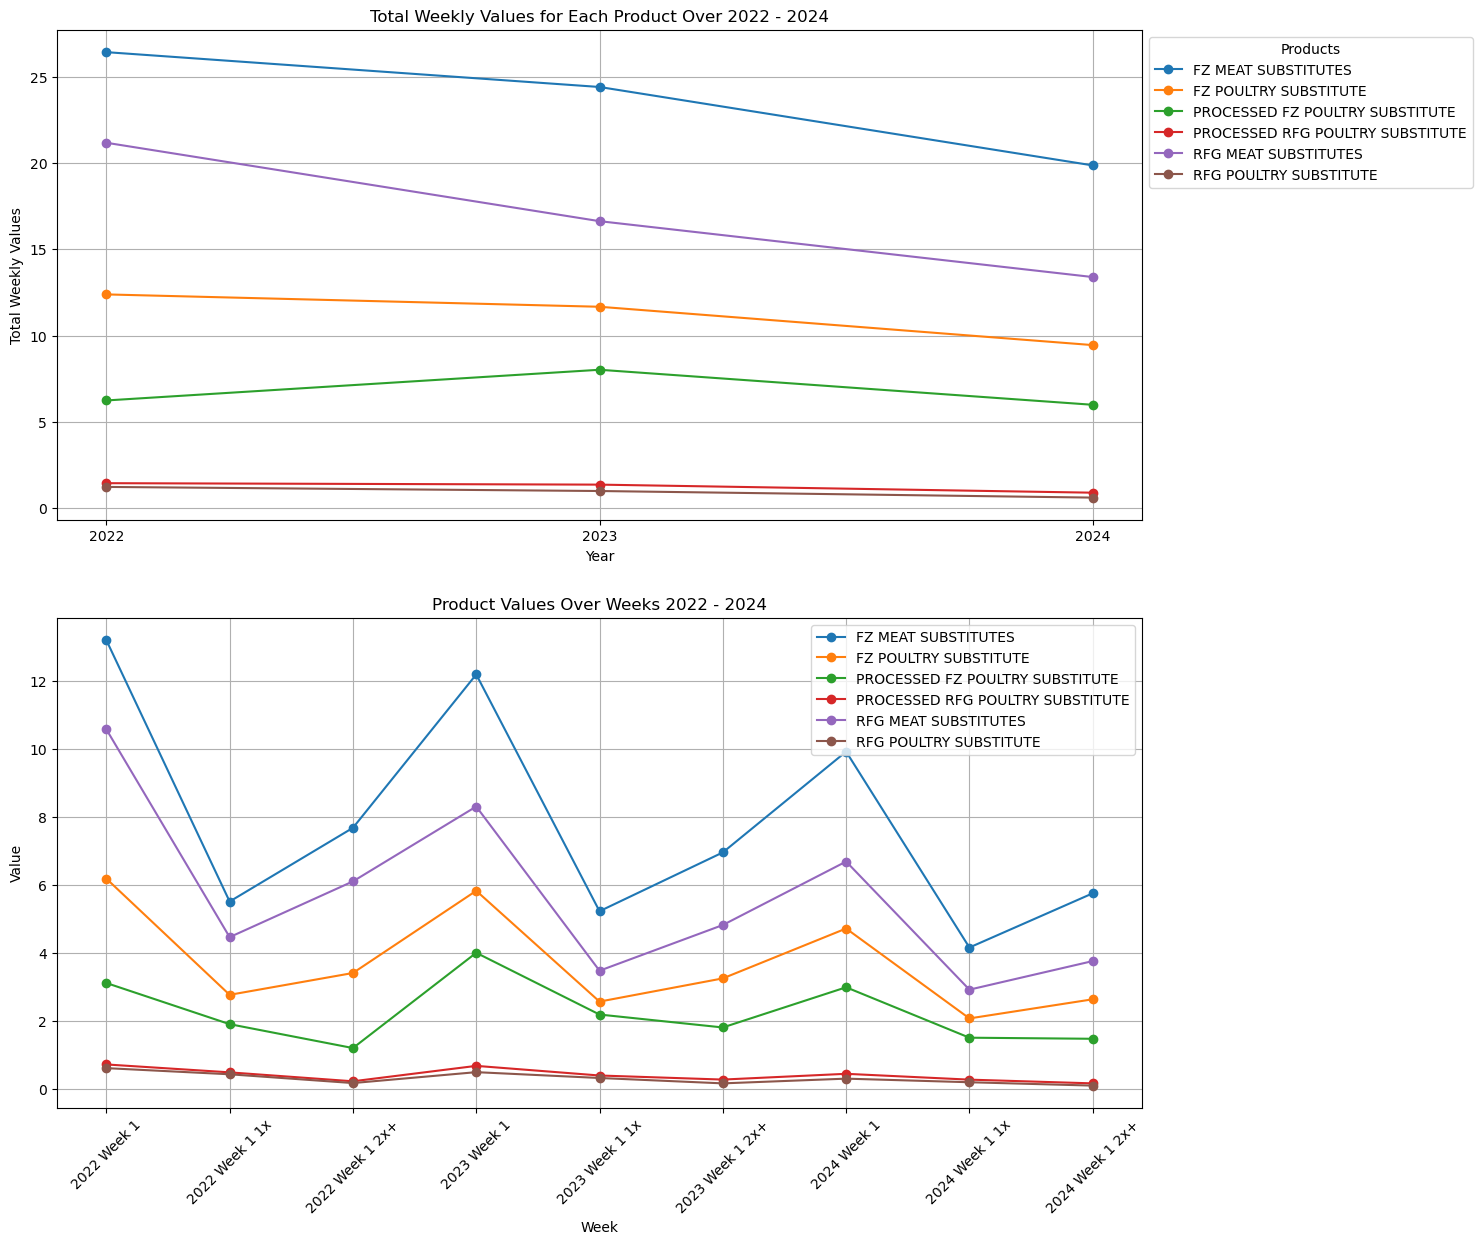

In [103]:
fig, axes = plt.subplots(2, 1, figsize=(14, 14))  # 2 Rows, 1 Column

# First subplot
for index, row in filtered_bb_df.iterrows():
    axes[0].plot(['2022', '2023', '2024'], row[['2022 Weeks', '2023 Weeks', '2024 Weeks']], marker='o', label=row['Product'])

axes[0].set_title('Total Weekly Values for Each Product Over 2022 - 2024')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Total Weekly Values')
axes[0].legend(title='Products', loc='upper left', bbox_to_anchor=(1, 1))
axes[0].grid(True)
axes[0].set_xticks(['2022', '2023', '2024'])

# Second subplot
# Reshaping the DataFrame to have one column for weeks and one for values
filtered_bb_df = filtered_bb_df.drop(columns = ['2022 Weeks', '2023 Weeks', '2024 Weeks'])
df_melted = filtered_bb_df.melt(id_vars=['Product'], var_name='Week', value_name='Value')
# Assuming 'Week' column has the pattern 'YYYY Week N', extract year for sorting
df_melted['Year'] = df_melted['Week'].apply(lambda x: x.split()[0])
df_melted.sort_values(by=['Product', 'Year'], inplace=True)

# Plot each product
week_ticks = sorted(df_melted['Week'].unique())

for product, group in df_melted.groupby('Product'):
    axes[1].plot(group['Week'], group['Value'], marker='o', label=product)

# Here is where you set the tick locations and labels
axes[1].set_xticks(week_ticks)  # Set the tick locations
axes[1].set_xticklabels(week_ticks, rotation=45)  # Set the tick labels with rotation

axes[1].set_xlabel('Week')
axes[1].set_ylabel('Value')
axes[1].set_title('Product Values Over Weeks 2022 - 2024')
axes[1].legend()
axes[1].grid(True)


Data used in these two visualizations are from same of week of different years respectively, which is not sufficient, but it did shows us a pattern that <strong> people like to buy non-processed poultry substitute </strong>

This also can be infered as people don't like to buy non-processed substitute. Probably because of the following reason:
1. Some processed foods contain a lot of salt, fat, and sugar
2. One study found that your risk of cancer goes up with the amount of ultra-processed food you eat.
3. Processed foods are easier for your body to digest than foods in their natural state. This means your body burns fewer calories when you digest processed foods.

Resource: https://www.webmd.com/diet/what-are-processed-foods

Suggestion:
<strong>Don't consider processed plant-based food</strong>

## Analysis: Demographic

In [104]:
demo_df = pd.read_excel('/Users/fuqiaozhi/Desktop/UTD Semesters/Spring 2024/BUAN 6337/Conagra Cleaned Data/Panel_Buyer Distribution.xlsx')

In [105]:
filtered_columns = demo_df.columns[((demo_df.columns.str.contains('SUBSTITUTE')) & (demo_df.columns.str.contains('Distribution'))) *
                                   ((demo_df.columns.str.contains('IMPOSSIBLE')) | 
                                    (demo_df.columns.str.contains('MORNINGSTAR')) |
                                    (demo_df.columns.str.contains('TURTLE ISLAND')) |
                                    (demo_df.columns.str.contains('BEYOND MEAT')) |
                                    (demo_df.columns.str.contains('LIGHTLIFE')) |
                                    (demo_df.columns.str.contains('PRIVATE LABEL')) |
                                    (demo_df.columns.str.contains('GARDEIN'))) &
                                    (demo_df.columns.str.contains('MEAT')) &
                                    (demo_df.columns.str.contains('FZ'))]
filtered_demo_df = demo_df[filtered_columns].copy()
filtered_demo_df.insert(0, 'HH Demo Summary', demo_df['HH Demo Summary'])
filtered_demo_df.insert(1, 'FZ MEAT SUBSTITUTES Buyer Distribution', demo_df['FZ MEAT SUBSTITUTES Buyer Distribution'])

In [106]:
income_index = filtered_demo_df.index[filtered_demo_df.apply(lambda row: row.astype(str).str.contains('ALL HH Income Per Capita', case=False).any(), axis=1)].tolist()
race_index = filtered_demo_df.index[filtered_demo_df.apply(lambda row: row.astype(str).str.contains('ALL HH Race', case=False).any(), axis=1)].tolist()
male_index = filtered_demo_df.index[filtered_demo_df.apply(lambda row: row.astype(str).str.contains('All HH Male Head Age', case=False).any(), axis=1)].tolist()
female_index = filtered_demo_df.index[filtered_demo_df.apply(lambda row: row.astype(str).str.contains('All HH Female Head Age', case=False).any(), axis=1)].tolist()

In [107]:
# income
income = filtered_demo_df.iloc[income_index[0]:income_index[0] + 4,]
income

,HH Demo Summary,FZ MEAT SUBSTITUTES Buyer Distribution,BEYOND MEAT-FZ MEAT SUBSTITUTES Buyer Distribution,GARDEIN-FZ MEAT SUBSTITUTES Buyer Distribution,IMPOSSIBLE-FZ MEAT SUBSTITUTES Buyer Distribution,MORNINGSTAR FARMS-FZ MEAT SUBSTITUTES Buyer Distribution,PRIVATE LABEL-FZ MEAT SUBSTITUTES Buyer Distribution,BEYOND MEAT-FZ POULTRY SUBSTITUTE Buyer Distribution,BEYOND MEAT-PROCESSED FZ POULTRY SUBSTITUTE Buyer Distribution
0,All HH Income Per Capita,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
1,Lower,21.501111,19.244178,20.190833,23.266886,21.251793,20.878481,26.406785,23.136957
2,Middle,38.151841,37.513159,37.134743,39.610589,38.867882,39.088363,42.154100,34.593465
3,Upper,40.347048,43.242663,42.674424,37.122525,39.880326,40.033156,31.439116,42.269578


In [108]:
# race
race = filtered_demo_df.iloc[race_index[0]:race_index[0] + 5,]
race

,HH Demo Summary,FZ MEAT SUBSTITUTES Buyer Distribution,BEYOND MEAT-FZ MEAT SUBSTITUTES Buyer Distribution,GARDEIN-FZ MEAT SUBSTITUTES Buyer Distribution,IMPOSSIBLE-FZ MEAT SUBSTITUTES Buyer Distribution,MORNINGSTAR FARMS-FZ MEAT SUBSTITUTES Buyer Distribution,PRIVATE LABEL-FZ MEAT SUBSTITUTES Buyer Distribution,BEYOND MEAT-FZ POULTRY SUBSTITUTE Buyer Distribution,BEYOND MEAT-PROCESSED FZ POULTRY SUBSTITUTE Buyer Distribution
10,All HH Race,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
11,White,70.531345,62.265087,68.173728,68.862241,73.154137,73.737900,55.766186,56.518555
12,African American,15.362635,21.085356,19.512886,19.782791,15.531266,12.814318,23.472959,25.337100
13,Asian,6.233765,7.445021,3.928456,NaN,4.539872,5.458918,NaN,NaN
14,Other / Unknown,7.872255,9.204536,8.384930,7.188307,6.774724,7.988864,NaN,NaN


In [109]:
# male
male = filtered_demo_df.iloc[male_index[0]:male_index[0] + 7,]
male

,HH Demo Summary,FZ MEAT SUBSTITUTES Buyer Distribution,BEYOND MEAT-FZ MEAT SUBSTITUTES Buyer Distribution,GARDEIN-FZ MEAT SUBSTITUTES Buyer Distribution,IMPOSSIBLE-FZ MEAT SUBSTITUTES Buyer Distribution,MORNINGSTAR FARMS-FZ MEAT SUBSTITUTES Buyer Distribution,PRIVATE LABEL-FZ MEAT SUBSTITUTES Buyer Distribution,BEYOND MEAT-FZ POULTRY SUBSTITUTE Buyer Distribution,BEYOND MEAT-PROCESSED FZ POULTRY SUBSTITUTE Buyer Distribution
50,All HH Male Head Age,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
51,Male 18-24 years old,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52,Male 25-34 years old,8.811639,10.764180,NaN,NaN,6.974736,9.739634,NaN,NaN
53,Male 35-44 years old,12.917360,13.428351,13.576328,15.313653,14.046876,9.994128,NaN,NaN
54,Male 45-54 years old,14.472585,16.019873,14.443474,15.442516,15.293972,15.376251,16.384711,NaN
55,Male 55-64 years old,13.275755,14.050255,11.632352,12.489107,13.198524,11.123788,NaN,NaN
56,Male 65 and over,16.753363,18.441496,16.477221,13.031948,17.741364,16.869609,11.115166,19.201329


In [110]:
# female
female = filtered_demo_df.iloc[female_index[0]:female_index[0] + 7,]
female

,HH Demo Summary,FZ MEAT SUBSTITUTES Buyer Distribution,BEYOND MEAT-FZ MEAT SUBSTITUTES Buyer Distribution,GARDEIN-FZ MEAT SUBSTITUTES Buyer Distribution,IMPOSSIBLE-FZ MEAT SUBSTITUTES Buyer Distribution,MORNINGSTAR FARMS-FZ MEAT SUBSTITUTES Buyer Distribution,PRIVATE LABEL-FZ MEAT SUBSTITUTES Buyer Distribution,BEYOND MEAT-FZ POULTRY SUBSTITUTE Buyer Distribution,BEYOND MEAT-PROCESSED FZ POULTRY SUBSTITUTE Buyer Distribution
85,All HH Female Head Age,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
86,Fem 18-24 years old,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87,Fem 25-34 years old,15.659797,15.528089,19.032518,19.021317,12.567261,17.730099,NaN,NaN
88,Fem 35-44 years old,16.114413,16.099015,15.171928,20.577808,17.264914,13.737331,18.530049,NaN
89,Fem 45-54 years old,18.576012,18.659183,17.467476,18.327827,19.328151,17.903698,18.040461,24.284965
90,Fem 55-64 years old,18.247378,18.286262,17.715781,17.973458,18.255903,18.195515,14.753728,16.348462
91,Fem 65 and over,21.815059,20.048089,21.895034,15.387931,22.024820,25.255014,12.692498,20.433027


<p>These 4 dataframe are meant to use as a inferece to decide advertising deployment strategy.</p>

TV Ads:
1. According to demographic information, locate a tv channel that a specifc group of people likely to watch. 
2. Deploy ads during show's break time.
3. The content can be food factories that demonstrate products safeness and cleanliness. Or, can be a video, from customer's perspective, that demonstrate the way you can cook it.
4. ads Cost could be extremely high for commercial.

Social media such as Tik Tok, Facebook, Ins:
1. The huge advantages of social media that provides short video service 
    1. except cost of producing video, almost at no cost on such a platform to play it.
    2. the convience of this kind of application contributes to high possibility that a user will see this ads regardless of time and location.
    3. users likely to watch news and any content they like on such application rather than tv, more flexible
    4. Letting influencer(especially influencer who eats plant-based products and fitness-related blogger) promote products costs less and is more easier to get attention.
2. Because these short videos are created by other users, the evaluations of a product are more objective, enhancing the credibility of the product.
3. Some pro users would write a post/blog to parallelly compare plant-based foods from different companies, it's a good chance to stand out.

In-store tryouts:
1. In grocery stores that's already have Conagra products, hold an in-store tryout event that freely provides sample of a product.
2. Change tryout product by week/day
3. Build the motivation and opportunity of first purchase.

# Model Dataset

In [31]:
filtered_df.columns

Index(['Geography', 'Year', 'Quarter', 'Month', 'Season', 'Form',
       'Manufacturer Name', 'Brand Name', 'Product Name', 'Flavor / Scent',
       'Meat Source', 'Unit Sales', 'Volume Sales', 'Dollar Sales',
       'Price per Unit', 'Price per Volume', 'Base Unit Sales',
       'Base Volume Sales', 'Base Dollar Sales', 'Incremental Units',
       'Incremental Volume', 'Incremental Dollars',
       'ACV Weighted Distribution', 'Period', 'Package Size', 'Portion',
       'Category'],
      dtype='object')

In [32]:
model_dataset = filtered_df[['Geography', 'Year', 'Quarter', 'Month', 'Season',  # Time
                             'Manufacturer Name', 'Product Name', 'Category', # Name
                             'Flavor / Scent', 'Form', 'Package Size', 'Portion', # Product Attributes
                             'Unit Sales', 'Volume Sales', 'Dollar Sales', 'Price per Unit']].reset_index() # Sales Values
model_dataset['Flavor / Scent'].unique()

array(['SPICY', 'VEGETABLE', 'SOUR', 'PORK', 'REGULAR', 'CHEESE', 'SWEET',
       'BEEF', 'BARBEQUE', 'CHICKEN', 'LIGHTLY SEASONED', 'FISH'],
      dtype=object)

In [137]:
# Final Check
model_dataset['Category'].unique()
model_dataset['Flavor / Scent'].unique()
model_dataset['Form'].unique()

array(['CRUMBLE', 'BURGER PATTY', 'BREAKFAST PATTY', 'BURGER', 'PATTY',
       'LINK', 'MEATBALL', 'FINGER', 'BREAST', 'TENDER', 'NUGGET', 'WING',
       'PIECE', 'STRIP', 'CUTLET', 'FILET', 'GROUND', 'SLICED', 'SLIDER',
       'CAKE', 'BITE', 'SLICE', 'TIP', 'BREAKFAST SAUSAGE PATTY',
       'HOT DOG', 'DELI SLICED', 'ROAST', 'ULTRA THIN SLICE', 'POPCORN',
       'BLOCK', 'FRANK', 'NOT STATED ON PACKAGE',
       'BREAKFAST SAUSAGE ROLL', 'CHUNK', 'PULLED', 'WHOLE', 'BALL',
       'SPLIT ROPE', 'BREAKFAST SAUSAGE LINK', 'RIBLET', 'CUBE',
       'BRATWURST', 'BREAKFAST LINK', 'ROLL', 'POPPER', 'SAUSAGE',
       'SAUSAGE PATTY', 'FRIES'], dtype=object)

In [33]:
# Without total us
model_dataset_no_total_us = model_dataset[model_dataset['Geography'] != 'Total US']
model_dataset_no_total_us

,Date,Geography,Year,Quarter,Month,Season,Manufacturer Name,Product Name,Category,Flavor / Scent,Form,Package Size,Portion,Unit Sales,Volume Sales,Dollar Sales,Price per Unit
0,2020-01-01,California,2020,1,1,Winter,BEYOND MEAT INC,FROZEN FEISTY MEAT SUBSTITUTE CRUMBLE 10 OZ,FROZEN MEAT,SPICY,CRUMBLE,10.0,Small,2883.544343,1802.215214,14153.270715,4.908290
1,2020-01-01,Mid-South,2020,1,1,Winter,KELLANOVA,FROZEN GARDEN VEGETABLE MEAT SUBSTITUTE BURGER...,FROZEN MEAT,VEGETABLE,BURGER,9.5,Small,9813.363484,5827.175237,36702.803983,3.740084
2,2020-01-01,Mid-South,2020,1,1,Winter,KELLANOVA,FROZEN GARDEN VEGETABLE MEAT SUBSTITUTE BURGER...,FROZEN MEAT,VEGETABLE,BURGER,56.0,Large,223.000000,780.500000,3535.380000,15.853722
3,2020-01-01,Mid-South,2020,1,1,Winter,KELLANOVA,FROZEN FALAFEL FALAFEL BURGER 16 OZ,FROZEN FALAFEL,SOUR,BURGER,16.0,Medium,225.000000,225.000000,1642.230000,7.298800
4,2020-01-01,Mid-South,2020,1,1,Winter,KELLANOVA,FROZEN CHORIZO MEAT SUBSTITUTE CRUMBLE 10 OZ,FROZEN MEAT,PORK,CRUMBLE,10.0,Small,3199.886009,1999.928756,12043.475816,3.763720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383365,2023-12-01,South Central,2023,4,12,Winter,CONAGRA BRANDS,FROZEN REGULAR MEAT SUBSTITUTE BURGER 8 OZ,FROZEN MEAT,REGULAR,BURGER,8.0,Small,948.466720,474.233360,4631.711155,4.883367
383366,2023-12-01,South Central,2023,4,12,Winter,CONAGRA BRANDS,FROZEN REGULAR MEAT SUBSTITUTE LINK 14 OZ,FROZEN MEAT,REGULAR,LINK,14.0,Medium,698.368059,611.072052,5605.002443,8.025857
383367,2023-12-01,South Central,2023,4,12,Winter,CONAGRA BRANDS,FROZEN SPICY ITALIAN MEAT SUBSTITUTE PIECE 14 OZ,FROZEN MEAT,SPICY,PIECE,14.0,Medium,8.161198,7.141048,43.529406,5.333703
383368,2023-12-01,South Central,2023,4,12,Winter,CONAGRA BRANDS,FROZEN REGULAR MEAT SUBSTITUTE GROUND 13.7 OZ,FROZEN MEAT,REGULAR,GROUND,13.7,Medium,8879.623875,7603.621924,44725.400207,5.036858


In [34]:
# Export model dataset
output_file = '/Users/fuqiaozhi/Desktop/UTD Semesters/Spring 2024/BUAN 6337/refined_model_dataset.csv'
model_dataset.to_csv(output_file, index=False)

# Note

I don't know much about marketing, but this is what I learned form this website:https://www.optimizely.com/optimization-glossary/marketing-strategy/

As you develop your marketing strategy, you should focus on the traditional 7 P’s of marketing: 
1. Product – how you satisfy customer needs
2. Price – how much customers are willing to pay for your product
3. Promotion – which channels you use to tell customers about your product
4. Place – where you sell your product
5. People – individuals who help sell your product to customers
6. Packaging – how you present your product to the customer
7. Process – how you deliver your product to customers

<strong>Product</strong>:
    Now we have analysis on product attributes (flavor, size), and potential products to be published<p></p>

<strong>Price</strong>:
    Price per Unit, Price frequency. Customers' acceptable range<p></p>

<strong>Promotion</strong>:
    What TV Channel, social media, radio channel. Google this. The final result is probably based on 'People'<p></p>
    
<strong>Place</strong>:
    Dollar sales per region. Mid U.S. is not a good region for development of plant-based product, but both the west & the east are.<p></p>

<strong>People</strong>:
    TBD. Demographic analysis is not what I expected.<p></p>

<strong>Packaging</strong>:
    Discovered in meeting. Should label the attribute of plant-based. Should make photograph look more healthy. Size analysis.<p></p>

<strong>Process</strong>:
    Have no idea.<p></p>

## Analysis: new_model_dataset 

In [35]:
df = pd.read_csv('/Users/fuqiaozhi/Desktop/UTD Semesters/Spring 2024/BUAN 6337/refined_model_dataset.csv')

In [36]:
df = df[df['Geography'] != 'Total US']
df

,Date,Geography,Year,Quarter,Month,Season,Manufacturer Name,Product Name,Category,Flavor / Scent,Form,Package Size,Portion,Unit Sales,Volume Sales,Dollar Sales,Price per Unit
0,2020-01-01,California,2020,1,1,Winter,BEYOND MEAT INC,FROZEN FEISTY MEAT SUBSTITUTE CRUMBLE 10 OZ,FROZEN MEAT,SPICY,CRUMBLE,10.0,Small,2883.544343,1802.215214,14153.270715,4.908290
1,2020-01-01,Mid-South,2020,1,1,Winter,KELLANOVA,FROZEN GARDEN VEGETABLE MEAT SUBSTITUTE BURGER...,FROZEN MEAT,VEGETABLE,BURGER,9.5,Small,9813.363484,5827.175237,36702.803983,3.740084
2,2020-01-01,Mid-South,2020,1,1,Winter,KELLANOVA,FROZEN GARDEN VEGETABLE MEAT SUBSTITUTE BURGER...,FROZEN MEAT,VEGETABLE,BURGER,56.0,Large,223.000000,780.500000,3535.380000,15.853722
3,2020-01-01,Mid-South,2020,1,1,Winter,KELLANOVA,FROZEN FALAFEL FALAFEL BURGER 16 OZ,FROZEN FALAFEL,SOUR,BURGER,16.0,Medium,225.000000,225.000000,1642.230000,7.298800
4,2020-01-01,Mid-South,2020,1,1,Winter,KELLANOVA,FROZEN CHORIZO MEAT SUBSTITUTE CRUMBLE 10 OZ,FROZEN MEAT,PORK,CRUMBLE,10.0,Small,3199.886009,1999.928756,12043.475816,3.763720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383365,2023-12-01,South Central,2023,4,12,Winter,CONAGRA BRANDS,FROZEN REGULAR MEAT SUBSTITUTE BURGER 8 OZ,FROZEN MEAT,REGULAR,BURGER,8.0,Small,948.466720,474.233360,4631.711155,4.883367
383366,2023-12-01,South Central,2023,4,12,Winter,CONAGRA BRANDS,FROZEN REGULAR MEAT SUBSTITUTE LINK 14 OZ,FROZEN MEAT,REGULAR,LINK,14.0,Medium,698.368059,611.072052,5605.002443,8.025857
383367,2023-12-01,South Central,2023,4,12,Winter,CONAGRA BRANDS,FROZEN SPICY ITALIAN MEAT SUBSTITUTE PIECE 14 OZ,FROZEN MEAT,SPICY,PIECE,14.0,Medium,8.161198,7.141048,43.529406,5.333703
383368,2023-12-01,South Central,2023,4,12,Winter,CONAGRA BRANDS,FROZEN REGULAR MEAT SUBSTITUTE GROUND 13.7 OZ,FROZEN MEAT,REGULAR,GROUND,13.7,Medium,8879.623875,7603.621924,44725.400207,5.036858


In [37]:
sales_by_flavor = df.groupby('Flavor / Scent')['Dollar Sales'].sum().reset_index()


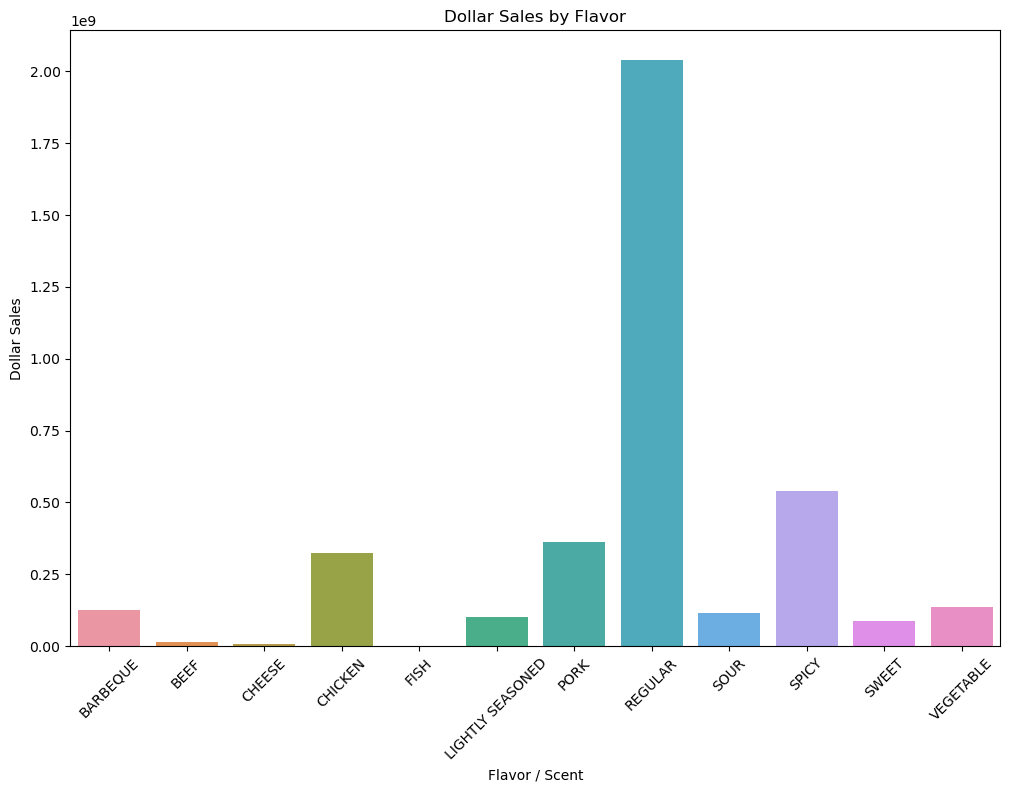

In [38]:
plt.figure(figsize=(12, 8))
sns.barplot(x='Flavor / Scent', y='Dollar Sales', data=sales_by_flavor)
plt.title('Dollar Sales by Flavor')
plt.xticks(rotation=45)  # Rotate labels if they overlap
plt.show()

In [39]:
grouped_data = df.groupby(['Flavor / Scent', 'Portion'])['Dollar Sales'].sum().unstack().fillna(0)

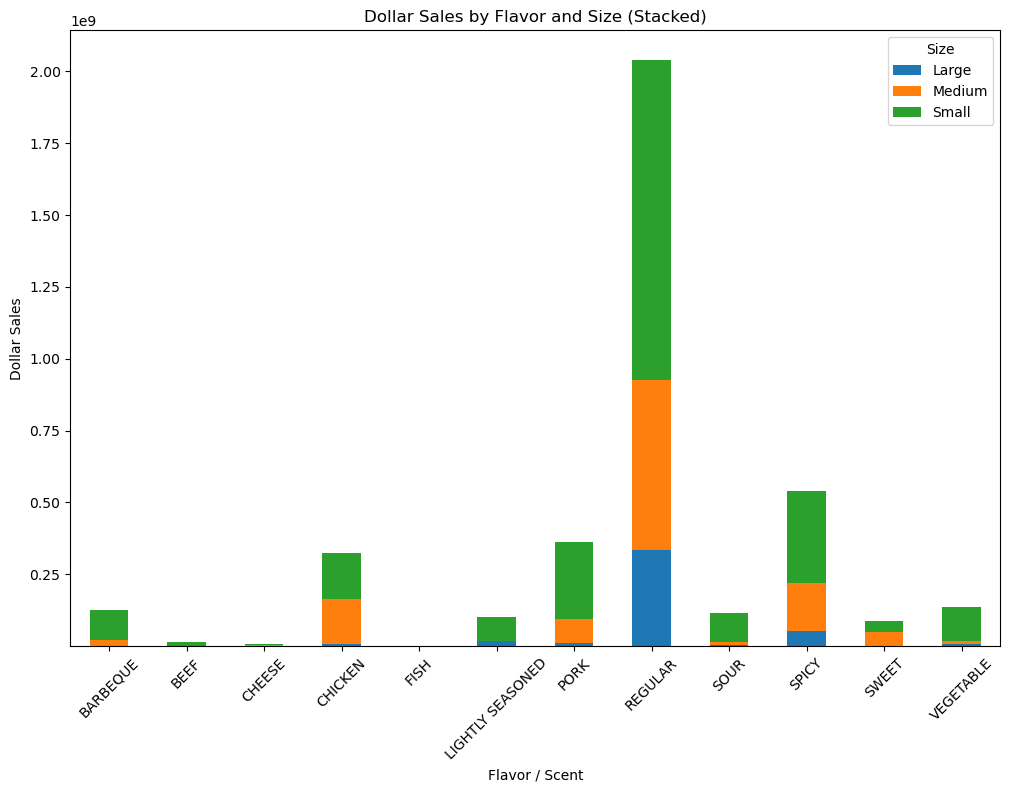

In [40]:
grouped_data.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title('Dollar Sales by Flavor and Size (Stacked)')
plt.ylabel('Dollar Sales')
plt.xlabel('Flavor / Scent')
plt.xticks(rotation=45)
plt.legend(title='Size')
plt.show()

In [46]:
df['Year'].unique()

array([2020, 2021, 2022, 2023])

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error


In [43]:
X = ['Geography', 'Year', 'Manufacturer Name', 'Category', 'Flavor / Scent', 'Form', 'Portion'] # add month or year, geography, ACV
#X = ['Geography', 'Year', 'Manufacturer Name', 'Category', 'Flavor / Scent', 'Form', 'Portion'] # add month or year, geography, ACV
#X = ['Geography', 'Portion', 'Flavor / Scent', 'Geography * Portion', 'Geography * Flavor / Scent', 'Year',' Month', 'Manufacturer Name', 'Category',' Form', 'ACV']
y = ['Dollar Sales']

categorical_features = X
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)
    ])

lasso = Lasso(alpha=0.1)
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', lasso)])

X_train, X_test, y_train, y_test = train_test_split(df[X], df[y], test_size=0.2, random_state=0)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print("Mean Squared Error:", mean_squared_error(y_test, y_pred))

# Coefficients of the model
feature_names = pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)

# Coefficients of the model
coefficients = pipeline.named_steps['regressor'].coef_

# Combine feature names and coefficients into a DataFrame for better readability
feature_coefficients = pd.DataFrame(zip(feature_names, coefficients), columns=['Feature', 'Coefficient'])
feature_coefficients.head(50)

Mean Squared Error: 298004920.42224646


/Users/fuqiaozhi/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:639: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 397820676901.375, tolerance: 13080106549.562593
  model = cd_fast.sparse_enet_coordinate_descent(


,Feature,Coefficient
0,Geography_California,731.409888
1,Geography_Great Lakes,-48.834864
2,Geography_Mid-South,563.639944
3,Geography_Northeast,4626.985346
4,Geography_Plains,-6892.184684
5,Geography_South Central,-4552.349882
6,Geography_Southeast,1916.472576
7,Geography_West,-0.000000
8,Year_2020,3497.985645
9,Year_2021,1660.443821


In [44]:
r_squared_train = pipeline.score(X_train, y_train)
print("R-squared on Training Set:", r_squared_train)

R-squared on Training Set: 0.27975828877298303


In [21]:
# output_file = '/Users/fuqiaozhi/Desktop/UTD Semesters/Spring 2024/BUAN 6337/model_stats.csv'
# feature_coefficients.to_csv(output_file, index=False)

In [48]:
# feature_coefficients[feature_coefficients['Coefficient'] > 0]

In [47]:
# feature_coefficients[feature_coefficients['Coefficient'] < 0]

In [24]:
df.columns

Index(['Date', 'Geography', 'Year', 'Quarter', 'Month', 'Season',
       'Manufacturer Name', 'Product Name', 'Category', 'Flavor / Scent',
       'Form', 'Package Size', 'Portion', 'Unit Sales', 'Volume Sales',
       'Dollar Sales', 'Price per Unit'],
      dtype='object')

## D-tree Model

In [49]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error


# Define the feature columns and target column
features = ['Geography', 'Year', 'Manufacturer Name', 'Category', 'Flavor / Scent', 'Form', 'Portion']
target = 'Dollar Sales'

# Preprocessing for categorical data
categorical_features = features
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Create preprocessing and training pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)
    ])

# Create a Decision Tree regression model within a pipeline
decision_tree = DecisionTreeRegressor(random_state=0)
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', decision_tree)])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=0)

# Fit the Decision Tree model
pipeline.fit(X_train, y_train)

# Evaluate the model on the testing set
y_pred_test = pipeline.predict(X_test)
print("Mean Squared Error on Test Set:", mean_squared_error(y_test, y_pred_test))
print("R-squared on Test Set:", pipeline.score(X_test, y_test))

# You can get the feature importances (which features are most important) like this:
feature_names = pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)
feature_importances = pipeline.named_steps['regressor'].feature_importances_

# Combine feature names and importances into a DataFrame for better readability
feature_importances_df = pd.DataFrame(zip(feature_names, feature_importances), columns=['Feature', 'Importance'])


Mean Squared Error on Test Set: 77665720.50731856
R-squared on Test Set: 0.8128415376845513


In [50]:
feature_importances_df.sort_values('Importance', ascending = False).head(50)

,Feature,Importance
12,Manufacturer Name_BEYOND MEAT INC,0.081988
26,Category_REFRIGERATED MEAT,0.065320
91,Portion_Small,0.065218
90,Portion_Medium,0.061616
4,Geography_Plains,0.058710
52,Form_BURGER PATTY,0.057671
17,Manufacturer Name_PRIVATE LABEL,0.051720
5,Geography_South Central,0.045636
3,Geography_Northeast,0.045386
11,Year_2023,0.042798


In [57]:
#X = ['Geography', 'Portion', 'Flavor / Scent', 'Geography * Portion', 'Geography * Flavor / Scent', 'Year',' Month', 'Manufacturer Name', 'Category',' Form', 'ACV']

In [56]:
import pandas as pd
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from patsy import dmatrices

formula = 'Q("Dollar Sales") ~ Q("Geography") + Q("Portion") + Q("Geography"):Q("Portion") + Q("Geography"):Q("Flavor / Scent") + Q("Year") + Q("Month") + Q("Manufacturer Name") + Q("Category") + Q("Form")'

Y, X = dmatrices(formula, df, return_type='dataframe')

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

lasso = LassoCV(cv=5, random_state=42)

lasso.fit(X_train, Y_train.values.ravel())

Y_pred = lasso.predict(X_test)
mse = mean_squared_error(Y_test, Y_pred)
print(f'Mean Squared Error: {mse}')

print(f'Lasso coefficients: {lasso.coef_}')


Mean Squared Error: 288358206.8477488
Lasso coefficients: [ 0.00000000e+00 -1.08745373e+03  1.88496160e+02  6.74491487e+03
 -5.90074730e+03 -0.00000000e+00  1.31773822e+03 -4.00433367e+02
  4.55495025e+03  6.13811202e+03 -1.57197715e+04  3.15852795e+03
 -9.47500098e+03 -2.60143768e+04 -2.67201067e+04 -2.57674686e+04
 -1.58194519e+04 -0.00000000e+00 -2.20408090e+03  3.44270469e+03
 -2.76483607e+03 -7.98837124e+03  4.24223657e+03  8.03336198e+02
 -8.72646328e+03  3.71173036e+03  1.33299471e+04 -1.90139797e+04
 -1.28134159e+04  1.58936961e+02  5.98189079e+03  9.65079668e+03
  1.23299441e+04  5.14938559e+03  5.49548438e+02  7.02781078e+03
 -1.05058029e+03 -4.73602766e+03 -6.28386648e+03  1.34414401e+03
  1.92156648e+02  2.15897831e+03  3.00362882e+03 -4.30460496e+03
 -4.97941443e+03 -1.64387862e+03  9.61949868e+03 -6.27204730e+03
  5.99771601e+03  2.73721987e+03 -2.62355211e+03 -1.58897589e+03
  2.09921962e+03 -1.60505952e+02 -9.65837337e+03 -1.78975520e+03
 -1.10544050e+04 -0.00000000e+00

In [58]:
r_squared = lasso.score(X_test, Y_test)
print(f'R-squared: {r_squared}')

R-squared: 0.28005004821508117


In [61]:
feature_coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lasso.coef_
})
feature_coef_df[feature_coef_df['Coefficient'] > 0]

,Feature,Coefficient
2,"Q(""Geography"")[T.Mid-South]",188.496160
3,"Q(""Geography"")[T.Northeast]",6744.914873
6,"Q(""Geography"")[T.Southeast]",1317.738221
8,"Q(""Portion"")[T.Medium]",4554.950249
9,"Q(""Portion"")[T.Small]",6138.112017
11,"Q(""Manufacturer Name"")[T.IMPOSSIBLE FOODS INC]",3158.527948
19,"Q(""Category"")[T.FROZEN MEAT ALTERNATIVE]",3442.704689
22,"Q(""Category"")[T.REFRIGERATED MEAT]",4242.236574
23,"Q(""Category"")[T.REFRIGERATED MEAT ALTERNATIVE]",803.336198
25,"Q(""Form"")[T.BITE]",3711.730358
